In [1]:
# ============================================
# Imports & base paths
# ============================================
import os, copy, time, json, datetime
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pandapower.networks as pn
from typing import List, Set
import subprocess
import glob  # for cross-run aggregation

plt.rcParams["figure.figsize"] = (7, 5)

# ====== CHANGE THIS IF YOUR FOLDER IS DIFFERENT ======
RESULTS_ROOT    = r"D:\my_projects\pmu-placement-gnn\results"
BASE_FIG_DIR    = os.path.join(RESULTS_ROOT, "figures")
BASE_METRIC_DIR = os.path.join(RESULTS_ROOT, "metrics")

print("RESULTS_ROOT:", RESULTS_ROOT)


RESULTS_ROOT: D:\my_projects\pmu-placement-gnn\results


In [2]:
# ============================================
# Run directory helpers
# ============================================
def make_run_id(run_tag=None):
    ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    return f"RUN_{ts}" + (f"_{run_tag}" if run_tag else "")

def make_dirs_for_system(run_id, system_name):
    """
    Create subfolders under figures/ and metrics/ for this run & system.
    Returns dict with paths for easy use.
    """
    fig_root    = os.path.join(BASE_FIG_DIR,    run_id, system_name)
    metric_root = os.path.join(BASE_METRIC_DIR, run_id, system_name)

    # Figures subfolders
    fig_base  = os.path.join(fig_root, "base")
    fig_worst = os.path.join(fig_root, "worst")
    fig_topk  = os.path.join(fig_root, "topk")

    # Metrics subfolders
    met_base     = os.path.join(metric_root, "baseline")
    met_rob      = os.path.join(metric_root, "robustness")
    met_summary  = os.path.join(metric_root, "summary")
    met_manifest = os.path.join(metric_root, "manifest")

    for p in [fig_base, fig_worst, fig_topk,
              met_base, met_rob, met_summary, met_manifest]:
        os.makedirs(p, exist_ok=True)

    return {
        "fig_base": fig_base, "fig_worst": fig_worst, "fig_topk": fig_topk,
        "met_base": met_base, "met_rob": met_rob, "met_summary": met_summary, "met_manifest": met_manifest,
        "fig_root": fig_root, "metric_root": metric_root
    }

def save_df(df, folder, filename):
    path = os.path.join(folder, filename)
    df.to_csv(path, index=False)
    print(f"Saved CSV: {path}")
    return path

def save_text(text, folder, filename):
    path = os.path.join(folder, filename)
    with open(path, "w", encoding="utf-8") as f:
        f.write(text)
    print(f"Saved TXT: {path}")
    return path


In [3]:
# ============================================
# Inkscape config for EMF export
# ============================================
ENABLE_EMF_EXPORT = True  # set False if you only want PNG + SVG
INKSCAPE_EXE = r"D:\Programs\inkscape\bin\inkscape.exe"  # <-- adjust to your system

def save_fig(fig, folder, filename, show_preview=True):
    """
    Save figure as:
      - PNG (raster)
      - SVG (vector)
      - optionally EMF (via Inkscape converting the SVG)

    If EMF export fails, it will print a warning but still save PNG + SVG.
    """
    if not filename.lower().endswith(".png"):
        filename = filename + ".png"

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename_ts = f"{timestamp}_{filename}"

    # Paths
    path_png = os.path.join(folder, filename_ts)
    path_svg = path_png[:-4] + ".svg"
    path_emf = path_png[:-4] + ".emf"

    # 1) PNG
    fig.savefig(path_png, dpi=220, bbox_inches="tight")
    print(f"Saved FIG PNG: {path_png}")

    # 2) SVG
    try:
        fig.savefig(path_svg, format="svg", bbox_inches="tight")
        print(f"Saved FIG SVG: {path_svg}")
    except Exception as e:
        print(f"[WARN] Could not save SVG ({e}). EMF export will also fail.")

    # 3) EMF via Inkscape (optional)
    if ENABLE_EMF_EXPORT:
        try:
            if not os.path.isfile(INKSCAPE_EXE):
                raise FileNotFoundError(f"Inkscape exe not found at: {INKSCAPE_EXE}")

            cmd = [
                INKSCAPE_EXE,
                path_svg,
                "--export-type=emf",
                f"--export-filename={path_emf}",
            ]
            print("Running Inkscape for EMF export:")
            print("  ", " ".join(f'"{c}"' if " " in c else c for c in cmd))
            subprocess.run(cmd, check=True)
            print(f"Saved FIG EMF (via Inkscape): {path_emf}")
        except Exception as e:
            print(f"[WARN] EMF export failed ({e}). "
                  f"Check ENABLE_EMF_EXPORT, INKSCAPE_EXE path, and Inkscape installation.")

    if show_preview:
        plt.show()
    else:
        plt.close(fig)

    return path_png  # primary path


In [4]:
# ============================================
# Graph building with node & edge features
# ============================================
def build_graph(net, include_transformers=True, include_three_winding=True):
    G = nx.Graph()

    # Nodes = buses, with voltage feature
    for b in net.bus.index:
        G.add_node(int(b), voltage_level=float(net.bus.at[b, 'vn_kv']))

    # Lines as edges (with features)
    for idx, row in net.line.iterrows():
        if "in_service" in row and not bool(row["in_service"]):
            continue
        G.add_edge(
            int(row["from_bus"]),
            int(row["to_bus"]),
            kind="line",
            idx=int(idx),
            length=float(row.get("length_km", 0.0)),
            resistance=float(row.get("r_ohm_per_km", 0.0)),
        )

    # 2-winding transformers as edges (with features)
    if include_transformers and len(net.trafo) > 0:
        for idx, row in net.trafo.iterrows():
            if "in_service" in row and not bool(row["in_service"]):
                continue
            G.add_edge(
                int(row["hv_bus"]),
                int(row["lv_bus"]),
                kind="trafo",
                idx=int(idx),
                sn_mva=float(row.get("sn_mva", 0.0)),
                impedance=float(row.get("vk_percent", 0.0)),
            )

    return G

def relabel_for_plot(G):
    # purely for nicer labels on plots
    return nx.convert_node_labels_to_integers(G, label_attribute="old_bus")


In [5]:
# ============================================
# Coverage & Greedy PMU placement
# ============================================
def observed_nodes(G: nx.Graph, pmu_nodes: List[int]) -> Set[int]:
    observed = set(pmu_nodes)
    for n in pmu_nodes:
        observed |= set(G.neighbors(n))
    return observed

def greedy_pmu_placement(G: nx.Graph) -> List[int]:
    all_nodes = set(G.nodes())
    observed = set()
    pmus = []
    while observed != all_nodes:
        best_bus, best_gain = None, -1
        for bus in all_nodes - set(pmus):
            gain = len(observed_nodes(G, [bus]) - observed)
            if gain > best_gain:
                best_gain, best_bus = gain, bus
        pmus.append(best_bus)
        observed |= observed_nodes(G, [best_bus])
    return pmus


In [6]:
# ============================================
# Fault simulation helpers
# ============================================
def deactivate(net, kind: str, idx: int):
    """
    Deactivates a specific component (line or transformer) in the network.
    Returns a *new* net.
    """
    net2 = copy.deepcopy(net)
    if kind == "line":
        net2.line.at[idx, "in_service"] = False
    elif kind == "trafo" and len(net2.trafo) > 0:
        net2.trafo.at[idx, "in_service"] = False
    else:
        raise ValueError(f"Invalid kind {kind}, expected 'line' or 'trafo'")
    return net2

def random_fault_simulation(net, max_faults=3, random_seed=None):
    """
    Randomly deactivates up to `max_faults` components (lines and transformers).
    Used to generate more diverse faulted topologies.
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    net_faulted = copy.deepcopy(net)

    # random number of faults between 1 and max_faults
    num_faults = np.random.randint(1, max_faults + 1)

    # choose lines to fault
    faulty_lines = []
    if len(net_faulted.line) > 0:
        line_indices = np.arange(len(net_faulted.line))
        faulty_lines = np.random.choice(
            line_indices,
            size=min(num_faults, len(line_indices)),
            replace=False
        )

    # choose trafos to fault
    faulty_trafos = []
    if len(net_faulted.trafo) > 0:
        trafo_indices = np.arange(len(net_faulted.trafo))
        faulty_trafos = np.random.choice(
            trafo_indices,
            size=min(num_faults, len(trafo_indices)),
            replace=False
        )

    # deactivate them
    for idx in faulty_lines:
        net_faulted.line.at[idx, "in_service"] = False
    for idx in faulty_trafos:
        net_faulted.trafo.at[idx, "in_service"] = False

    return net_faulted


In [7]:
# ============================================
# Outage evaluation helpers
# ============================================
def failed_edge_buses(net, kind: str, idx: int):
    """Return (u, v) original bus IDs for the failed element."""
    if kind == "line":
        u = int(net.line.at[idx, "from_bus"])
        v = int(net.line.at[idx, "to_bus"])
        return (u, v)
    elif kind == "trafo" and len(net.trafo) > 0:
        u = int(net.trafo.at[idx, "hv_bus"])
        v = int(net.trafo.at[idx, "lv_bus"])
        return (u, v)
    else:
        return None

def evaluate_outage(net, base_pmus, kind, idx):
    """
    Simulate outage (line or trafo), rebuild graph,
    compute coverage with base PMUs and with re-optimized greedy PMUs.
    """
    net_out = deactivate(net, kind, idx)
    G_out = build_graph(net_out)

    cov_fixed = 100.0 * len(observed_nodes(G_out, base_pmus)) / len(G_out.nodes())

    t0 = time.time()
    pmus_reopt = greedy_pmu_placement(G_out)
    t1 = time.time()

    cov_reopt = 100.0 * len(observed_nodes(G_out, pmus_reopt)) / len(G_out.nodes())
    components = nx.number_connected_components(G_out)
    u, v = failed_edge_buses(net, kind, idx)

    return {
        "kind": kind,
        "idx": int(idx),
        "nodes": G_out.number_of_nodes(),
        "edges": G_out.number_of_edges(),
        "components": components,
        "coverage_fixed_%": cov_fixed,
        "pmus_fixed": len(base_pmus),
        "coverage_reopt_%": cov_reopt,
        "pmus_reopt": len(pmus_reopt),
        "delta_pmus": len(pmus_reopt) - len(base_pmus),
        "greedy_time_s": round(t1 - t0, 4),
        "pmus_reopt_list": json.dumps(sorted(pmus_reopt)),
        "failed_u": u,
        "failed_v": v
    }, G_out


In [8]:
# ============================================
# Plot helpers
# ============================================
def plot_with_pmus(G, pmus, title, failed_edge=None, highlight_unobserved=False):
    """
    Visual PMU plot with:
    - bigger & bold title
    - legend in upper-right
    - optional highlighting of unobserved nodes
    - optional highlighting of failed edge
    """
    import matplotlib.patches as mpatches
    import matplotlib.lines as mlines

    Gd = relabel_for_plot(G)
    # map relabeled -> original and back
    id_map = {new: data["old_bus"] for new, data in Gd.nodes(data=True)}
    inv_map = {v: k for k, v in id_map.items()}  # original -> relabeled

    pmus_relabeled = [inv_map[p] for p in pmus]
    if highlight_unobserved:
        obs = observed_nodes(G, pmus)
        obs_relabeled = {inv_map[o] for o in obs}
    else:
        obs_relabeled = set()

    # Layout
    pos = nx.kamada_kawai_layout(Gd)

    # ---- Visual parameters
    node_size        = 1200
    label_font_size  = 16   # bus number font
    title_font_size  = 28   # plot title size
    legend_font_size = 18   # legend labels
    legend_title_size= 20

    default_node_color = "skyblue"   # observed bus
    pmu_node_color     = "orange"    # PMU bus
    unobs_node_color   = "lightgray" # unobserved bus
    edge_color         = "black"
    edge_width         = 1.8

    # ---- Node colors
    colors = []
    for n in Gd.nodes():
        if n in pmus_relabeled:
            colors.append(pmu_node_color)
        elif highlight_unobserved and n not in obs_relabeled:
            colors.append(unobs_node_color)
        else:
            colors.append(default_node_color)

    fig, ax = plt.subplots(figsize=(15, 15))

    # Draw graph
    nx.draw(
        Gd, pos,
        with_labels=True,
        node_color=colors,
        node_size=node_size,
        edgecolors="black",
        edge_color=edge_color,
        width=edge_width,
        font_size=label_font_size,
        font_weight="bold",   # bold bus labels
        ax=ax,
    )

    # Failed edge overlay (thicker, red)
    failed_drawn = False
    if failed_edge is not None:
        u0, v0 = failed_edge
        if (u0 in inv_map) and (v0 in inv_map):
            u, v = inv_map[u0], inv_map[v0]
            ax.plot(
                [pos[u][0], pos[v][0]],
                [pos[u][1], pos[v][1]],
                linewidth=6,
                color="red",
                alpha=0.9
            )
            failed_drawn = True

    # ---- Legend
    legend_handles = [
        mpatches.Patch(color=pmu_node_color,     label="PMU bus"),
        mpatches.Patch(color=default_node_color, label="Observed bus"),
    ]
    if highlight_unobserved:
        legend_handles.append(
            mpatches.Patch(color=unobs_node_color, label="Unobserved bus")
        )
    if failed_drawn:
        legend_handles.append(
            mlines.Line2D([], [], color="red", linewidth=4, label="Failed branch")
        )

    leg = ax.legend(
        handles=legend_handles,
        loc="upper right",
        bbox_to_anchor=(0.98, 0.98),
        borderaxespad=0.3,
        fontsize=legend_font_size,
        title="Legend",
        title_fontsize=legend_title_size,
        framealpha=0.9,
    )

    # bold legend text
    for text in leg.get_texts():
        text.set_fontweight("bold")
    leg.get_title().set_fontweight("bold")

    # ---- Title
    ax.set_title(title, fontsize=title_font_size, fontweight="bold")

    fig.tight_layout()
    return fig


In [9]:
# %%
# ============================================
# Run suite: baseline + faults + metrics + figures + manifest
# ============================================
def run_suite(
    net,
    system_name="IEEE14",
    top_k=5,
    preview=True,
    run_tag=None,
    fault_mode="n-1",
    num_random_scenarios=5,
    max_faults_random=3,
):
    """
    Run a full greedy-based analysis for one system:

      - Build base graph and greedy PMU set
      - Sweep faulted topologies to assess robustness
      - Save metrics, plots, and manifest

    fault_mode:
      - "n-1"   : single line/trafo outage on the intact net
      - "random": multi-fault random mode (for richer datasets)
    """
    # ----------------- create run folders -----------------
    run_id = make_run_id(run_tag=run_tag)
    P = make_dirs_for_system(run_id, system_name)

    # ----------------- base graph + PMUs ------------------
    t0 = time.time()
    G = build_graph(net)
    t1 = time.time()

    base_pmus_t0 = time.time()
    base_pmus = greedy_pmu_placement(G)
    base_pmus_t1 = time.time()

    base_graph_time_s  = round(t1 - t0, 4)
    base_greedy_time_s = round(base_pmus_t1 - base_pmus_t0, 4)

    base_cov = 100.0 * len(observed_nodes(G, base_pmus)) / len(G.nodes())
    base_components = nx.number_connected_components(G)

    df_base = pd.DataFrame([{
        "run_id": run_id,
        "system": system_name,
        "nodes": G.number_of_nodes(),
        "edges": G.number_of_edges(),
        "components": base_components,
        "pmus": json.dumps(sorted(base_pmus)),
        "num_pmus": len(base_pmus),
        "coverage_%": base_cov,
        "base_graph_time_s": base_graph_time_s,
        "base_greedy_time_s": base_greedy_time_s
    }])
    base_csv = save_df(df_base, P["met_base"], f"baseline_{system_name}.csv")

    # base figure = main OPP layout
    fig = plot_with_pmus(G, base_pmus, f"Base PMUs ({system_name})")
    base_png = save_fig(fig, P["fig_base"], f"base_{system_name}.png", show_preview=preview)

    # ----------------- fault sweep -----------------
    sweep_t0 = time.time()
    rows = []

    if fault_mode == "n-1":
        # single outage on intact net
        for idx in net.line.index:
            rec, _ = evaluate_outage(net, base_pmus, "line", int(idx))
            rows.append(rec)
        for idx in net.trafo.index:
            rec, _ = evaluate_outage(net, base_pmus, "trafo", int(idx))
            rows.append(rec)

    elif fault_mode == "random":
        # random multi-fault nets, then all outages on them
        for _ in range(num_random_scenarios):
            random_seed = np.random.randint(0, 10_000)
            net_faulted = random_fault_simulation(net, max_faults=max_faults_random, random_seed=random_seed)

            for idx in net_faulted.line.index:
                rec, _ = evaluate_outage(net_faulted, base_pmus, "line", int(idx))
                rows.append(rec)

            for idx in net_faulted.trafo.index:
                rec, _ = evaluate_outage(net_faulted, base_pmus, "trafo", int(idx))
                rows.append(rec)
    else:
        raise ValueError(f"Invalid fault_mode={fault_mode!r}. Use 'n-1' or 'random'.")

    sweep_t1 = time.time()
    sweep_total_time_s = round(sweep_t1 - sweep_t0, 4)

    df_rob = pd.DataFrame(rows)

    if len(df_rob):
        df_rob["keeps_100%"] = (df_rob["coverage_fixed_%"] >= 100.0 - 1e-9)
        robustness = df_rob["keeps_100%"].mean() * 100.0
        avg_delta = df_rob["delta_pmus"].mean()
    else:
        robustness = 100.0
        avg_delta = 0.0

    rob_csv = save_df(df_rob, P["met_rob"], f"robustness_{system_name}.csv")

    # ----------------- critical lines table -----------------
    crit_csv = None
    if len(df_rob):
        group_cols = ["kind", "idx", "failed_u", "failed_v"]
        df_crit = (
            df_rob
            .groupby(group_cols, as_index=False)
            .agg(
                outages=("delta_pmus", "size"),
                avg_delta_pmus=("delta_pmus", "mean"),
                max_delta_pmus=("delta_pmus", "max"),
                avg_cov_fixed=("coverage_fixed_%", "mean"),
                avg_cov_reopt=("coverage_reopt_%", "mean"),
            )
        )
        df_crit["is_critical"] = df_crit["avg_delta_pmus"] > 0.0
        crit_csv = save_df(df_crit, P["met_summary"], f"critical_lines_{system_name}.csv")

        df_crit_sorted = df_crit.sort_values(
            ["is_critical", "avg_delta_pmus", "max_delta_pmus"],
            ascending=[False, False, False]
        )
        print(f"\nTop critical lines for {system_name}:")
        print(df_crit_sorted.head(10)[["kind", "idx", "failed_u", "failed_v",
                                       "avg_delta_pmus", "max_delta_pmus", "is_critical"]])
    else:
        df_crit = pd.DataFrame([])

    # ----------------- rank Top-K worst outages -----------------
    if len(df_rob):
        df_rob["score"] = (
            (100.0 - df_rob["coverage_fixed_%"])
            + 10.0 * df_rob["delta_pmus"]
            + 5.0 * (df_rob["components"] - 1)
        )
        df_sorted = df_rob.sort_values("score", ascending=False)
        df_unique = df_sorted.drop_duplicates(subset=["kind", "idx"], keep="first")
        top = df_unique.head(top_k)
    else:
        top = pd.DataFrame([])

    df_summary = pd.DataFrame([{
        "run_id": run_id,
        "system": system_name,
        "nodes": G.number_of_nodes(),
        "edges": G.number_of_edges(),
        "base_num_pmus": len(base_pmus),
        "base_coverage_%": base_cov,
        "N-1_robustness_%": round(float(robustness), 1),
        "avg_delta_pmus_outage": round(float(avg_delta), 3),
        "base_graph_time_s": base_graph_time_s,
        "base_greedy_time_s": base_greedy_time_s,
        "sweep_total_time_s": sweep_total_time_s,
        "topK_used": top_k,
        "fault_mode": fault_mode,
    }])
    sum_csv = save_df(df_summary, P["met_summary"], f"summary_{system_name}.csv")

    # ----------------- worst outage figures -----------------
    worst_pngs = []
    for rank, rec in enumerate(top.to_dict("records"), start=1):
        net_bad = deactivate(net, rec["kind"], int(rec["idx"]))
        G_bad   = build_graph(net_bad)
        failed  = (rec["failed_u"], rec["failed_v"])

        fig_before = plot_with_pmus(
            G_bad,
            json.loads(df_base["pmus"].iloc[0]),
            f"Before (base PMUs) — {rec['kind']} idx={int(rec['idx'])} — {system_name}",
            failed_edge=failed,
            highlight_unobserved=True
        )
        png_before = save_fig(
            fig_before, P["fig_worst"],
            f"worst{rank}_before_{system_name}_{rec['kind']}_{int(rec['idx'])}.png",
            show_preview=preview
        )

        fig_after = plot_with_pmus(
            G_bad,
            json.loads(rec["pmus_reopt_list"]),
            f"After (re-optimized) — {rec['kind']} idx={int(rec['idx'])} — {system_name}"
        )
        png_after = save_fig(
            fig_after, P["fig_worst"],
            f"worst{rank}_after_{system_name}_{rec['kind']}_{int(rec['idx'])}.png",
            show_preview=preview
        )

        worst_pngs.append((png_before, png_after))

    # ----------------- Top-K bar chart -----------------
    if len(top):
        labels = [f"{k}-{i}" for k, i in zip(top["kind"], top["idx"])]
        heights = top["score"].to_list()
        fig_top, ax = plt.subplots()
        ax.bar(range(len(labels)), heights)
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45, ha="right")
        ax.set_ylabel("Criticality score (coverage drop + ΔPMUs + components)")
        ax.set_title(f"Top-{len(labels)} critical outages — {system_name}")
        fig_top.tight_layout()
        topk_png = save_fig(fig_top, P["fig_topk"], f"topk_outages_{system_name}.png", show_preview=preview)
    else:
        topk_png = None

    # ----------------- human-readable TXT summary -----------------
    bullets = []
    bullets.append(f"Run ID: {run_id} | System: {system_name}")
    bullets.append(f"- Nodes={G.number_of_nodes()}, Edges={G.number_of_edges()}, Components={base_components}")
    bullets.append(f"- Base PMUs: {sorted(base_pmus)} (#{len(base_pmus)}) | Coverage={base_cov:.1f}%")
    bullets.append(f"- N-1 robustness (base PMUs keep 100%): {robustness:.1f}%")
    bullets.append(f"- Avg ΔPMUs under outage: {avg_delta:.3f}")
    bullets.append(f"- Runtimes: build_graph={base_graph_time_s}s | greedy_base={base_greedy_time_s}s | sweep_total={sweep_total_time_s}s")
    bullets.append("")
    bullets.append("CSV files:")
    bullets.append(f"  • {os.path.relpath(base_csv, BASE_METRIC_DIR)} — baseline metrics")
    bullets.append(f"  • {os.path.relpath(rob_csv, BASE_METRIC_DIR)} — robustness / outages")
    bullets.append(f"  • {os.path.relpath(sum_csv, BASE_METRIC_DIR)} — summary stats")
    if crit_csv is not None:
        bullets.append(f"  • {os.path.relpath(crit_csv, BASE_METRIC_DIR)} — critical lines (aggregated)")
    bullets.append("")
    bullets.append("Figures:")
    bullets.append(f"  • {os.path.relpath(base_png, BASE_FIG_DIR)} — Base placement")
    if topk_png is not None:
        bullets.append(f"  • {os.path.relpath(topk_png, BASE_FIG_DIR)} — Top-K outage bar chart")
    for pb, pa in worst_pngs:
        bullets.append(f"  • {os.path.relpath(pb, BASE_FIG_DIR)} — BEFORE: base PMUs, failed branch marked, unobserved gray")
        bullets.append(f"  • {os.path.relpath(pa, BASE_FIG_DIR)} — AFTER: re-optimized PMUs")

    sum_txt = save_text("\n".join(bullets), P["met_summary"], f"summary_{system_name}.txt")

    # ----------------- manifest JSON (for GNN dataset builder) -----------------
    manifest = {
        "run_id": run_id,
        "system": system_name,
        "created": time.ctime(),
        "paths": P,
        "artifacts": {
            "baseline_csv": base_csv,
            "robustness_csv": rob_csv,
            "summary_csv": sum_csv,
            "summary_txt": sum_txt,
            "critical_lines_csv": crit_csv,
            "base_png": base_png,
            "worst_pngs": worst_pngs,
            "topk_png": topk_png
        },
        "metrics": {
            "nodes": G.number_of_nodes(),
            "edges": G.number_of_edges(),
            "base_num_pmus": len(base_pmus),
            "base_coverage_%": base_cov,
            "robustness_%": float(round(robustness, 3)),
            "avg_delta_pmus": float(round(avg_delta, 3)),
            "base_graph_time_s": base_graph_time_s,
            "base_greedy_time_s": base_greedy_time_s,
            "sweep_total_time_s": sweep_total_time_s,
            "fault_mode": fault_mode,
        },
        "topK": top.to_dict("records") if len(top) else []
    }

    manifest_path = os.path.join(P["met_manifest"], f"manifest_{system_name}.json")
    with open(manifest_path, "w", encoding="utf-8") as f:
        json.dump(manifest, f, indent=2)
    print(f"Saved manifest: {manifest_path}")

    return run_id, manifest


Saved CSV: D:\my_projects\pmu-placement-gnn\results\metrics\RUN_20251128_054024_greedy_n1_14\IEEE14\baseline\baseline_IEEE14.csv
Saved FIG PNG: D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\base\20251128_054024_base_IEEE14.png
Saved FIG SVG: D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\base\20251128_054024_base_IEEE14.svg
Running Inkscape for EMF export:
   D:\Programs\inkscape\bin\inkscape.exe D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\base\20251128_054024_base_IEEE14.svg --export-type=emf --export-filename=D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\base\20251128_054024_base_IEEE14.emf
Saved FIG EMF (via Inkscape): D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\base\20251128_054024_base_IEEE14.emf


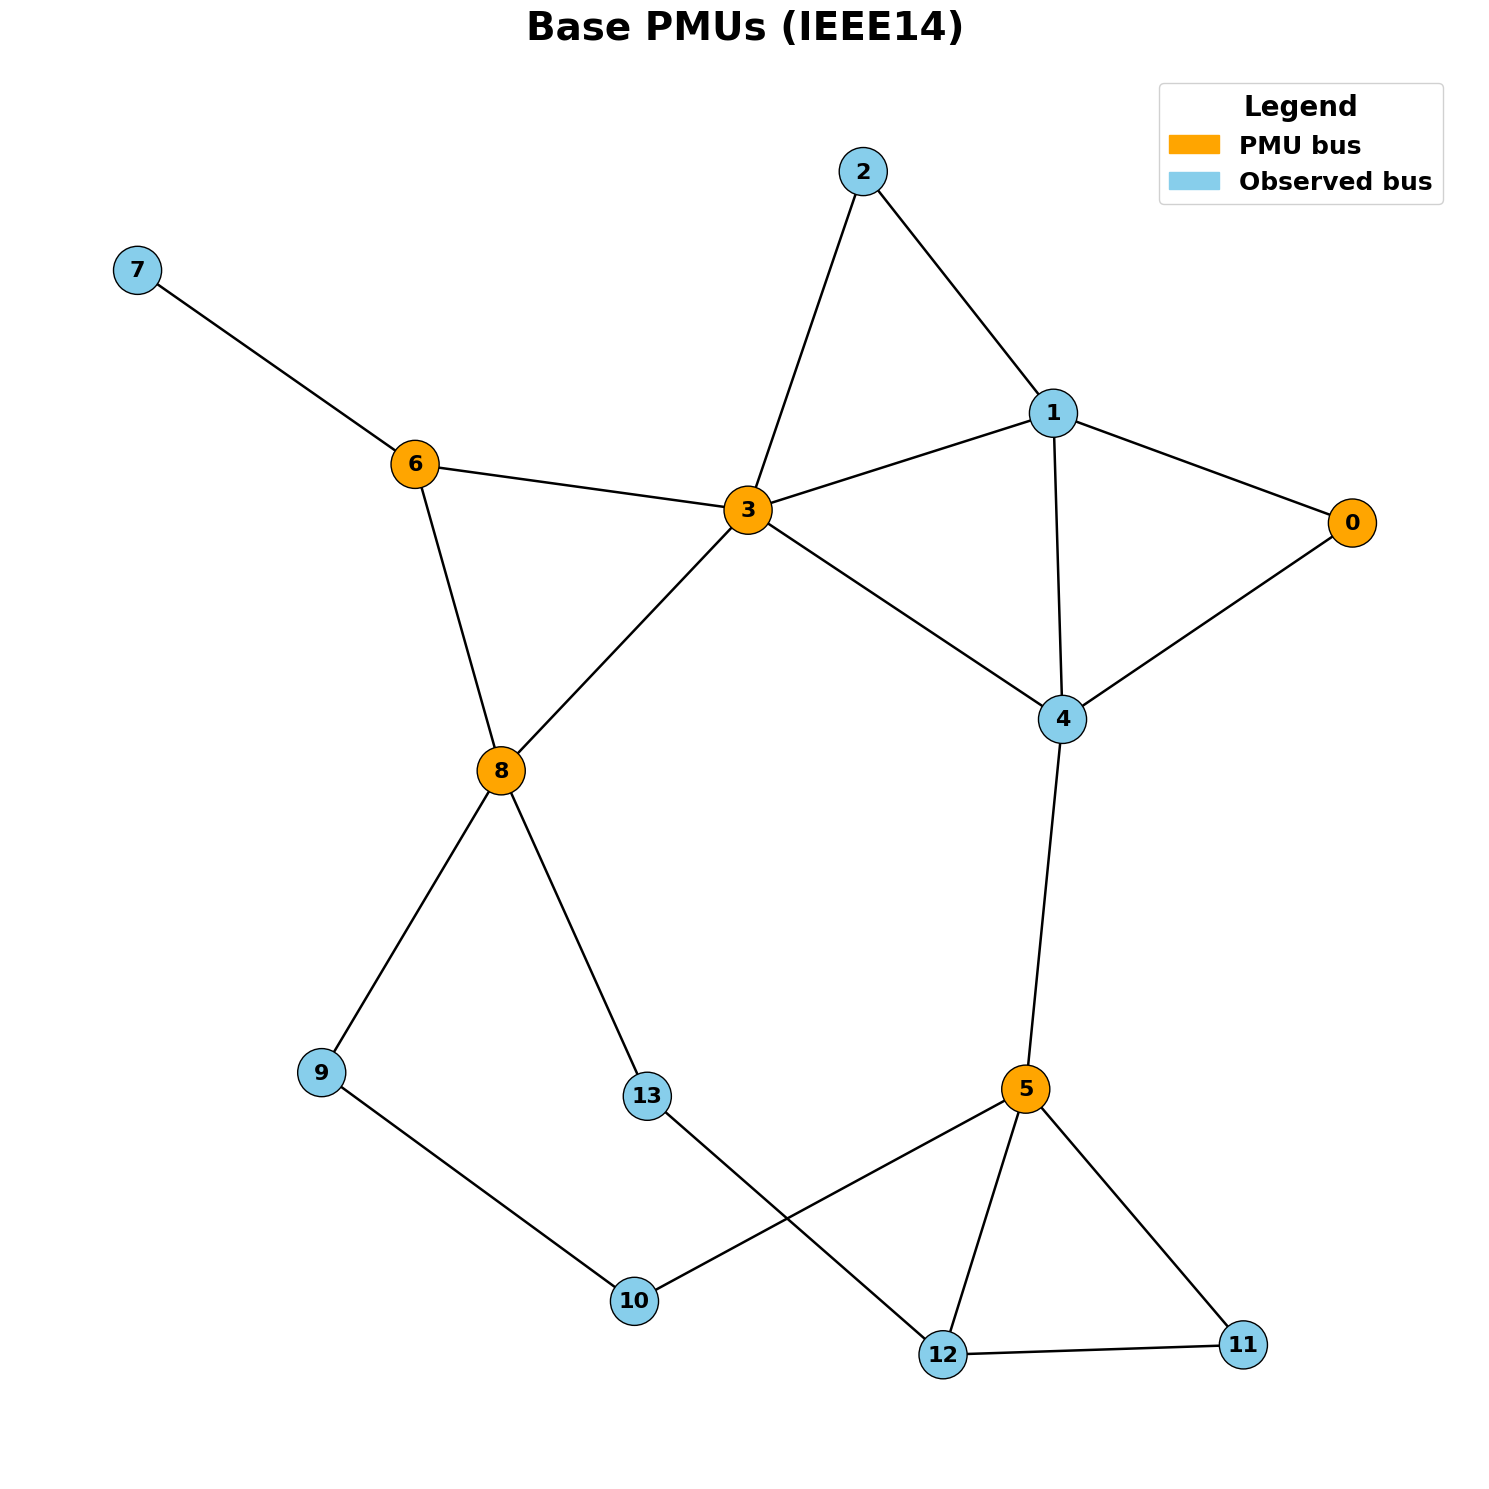

Saved CSV: D:\my_projects\pmu-placement-gnn\results\metrics\RUN_20251128_054024_greedy_n1_14\IEEE14\robustness\robustness_IEEE14.csv
Saved CSV: D:\my_projects\pmu-placement-gnn\results\metrics\RUN_20251128_054024_greedy_n1_14\IEEE14\summary\critical_lines_IEEE14.csv

Top critical lines for IEEE14:
    kind  idx  failed_u  failed_v  avg_delta_pmus  max_delta_pmus  is_critical
9   line    9         5        12             1.0               1         True
10  line   10         8         9             1.0               1         True
11  line   11         8        13             1.0               1         True
0   line    0         0         1             0.0               0        False
1   line    1         0         4             0.0               0        False
2   line    2         1         2             0.0               0        False
3   line    3         1         3             0.0               0        False
4   line    4         1         4             0.0               0    

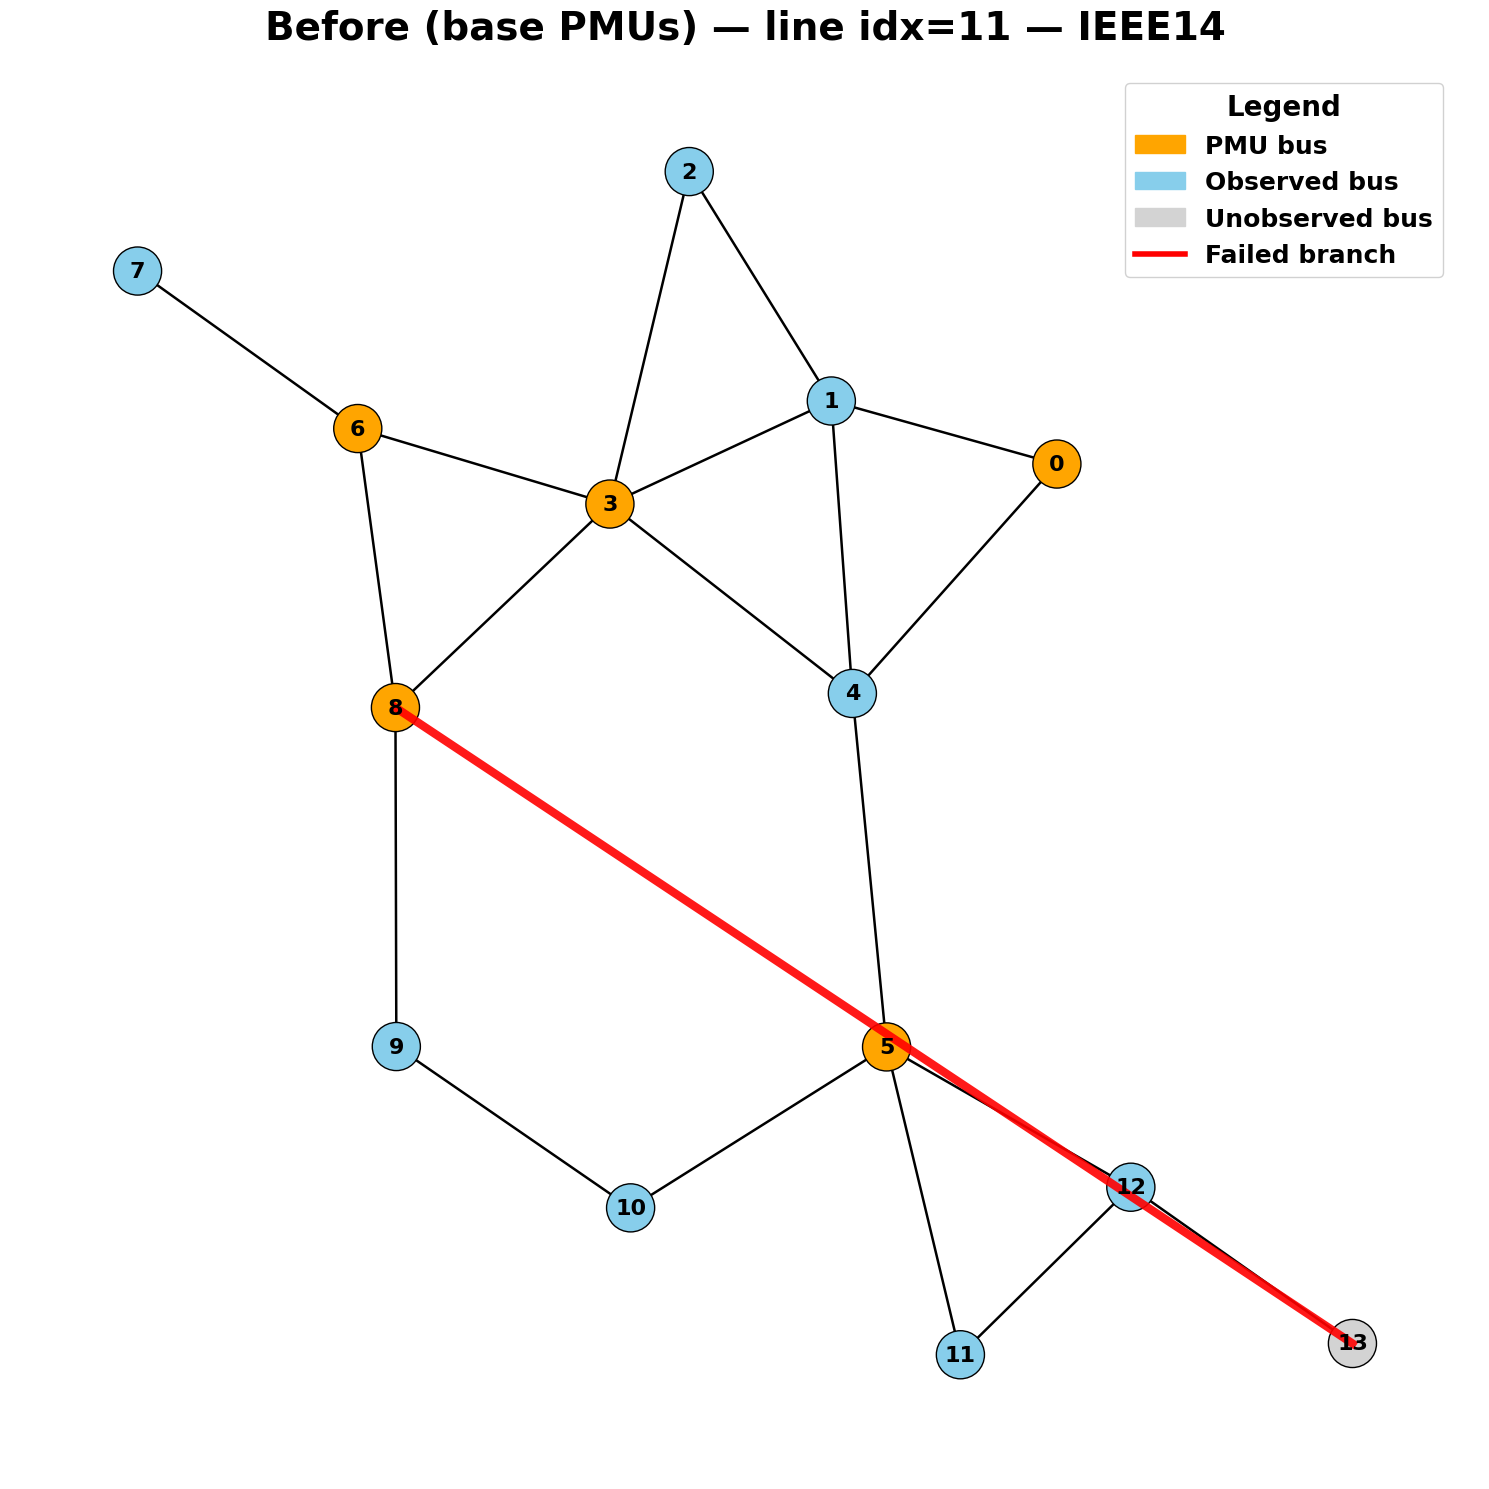

Saved FIG PNG: D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054031_worst1_after_IEEE14_line_11.png
Saved FIG SVG: D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054031_worst1_after_IEEE14_line_11.svg
Running Inkscape for EMF export:
   D:\Programs\inkscape\bin\inkscape.exe D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054031_worst1_after_IEEE14_line_11.svg --export-type=emf --export-filename=D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054031_worst1_after_IEEE14_line_11.emf
Saved FIG EMF (via Inkscape): D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054031_worst1_after_IEEE14_line_11.emf


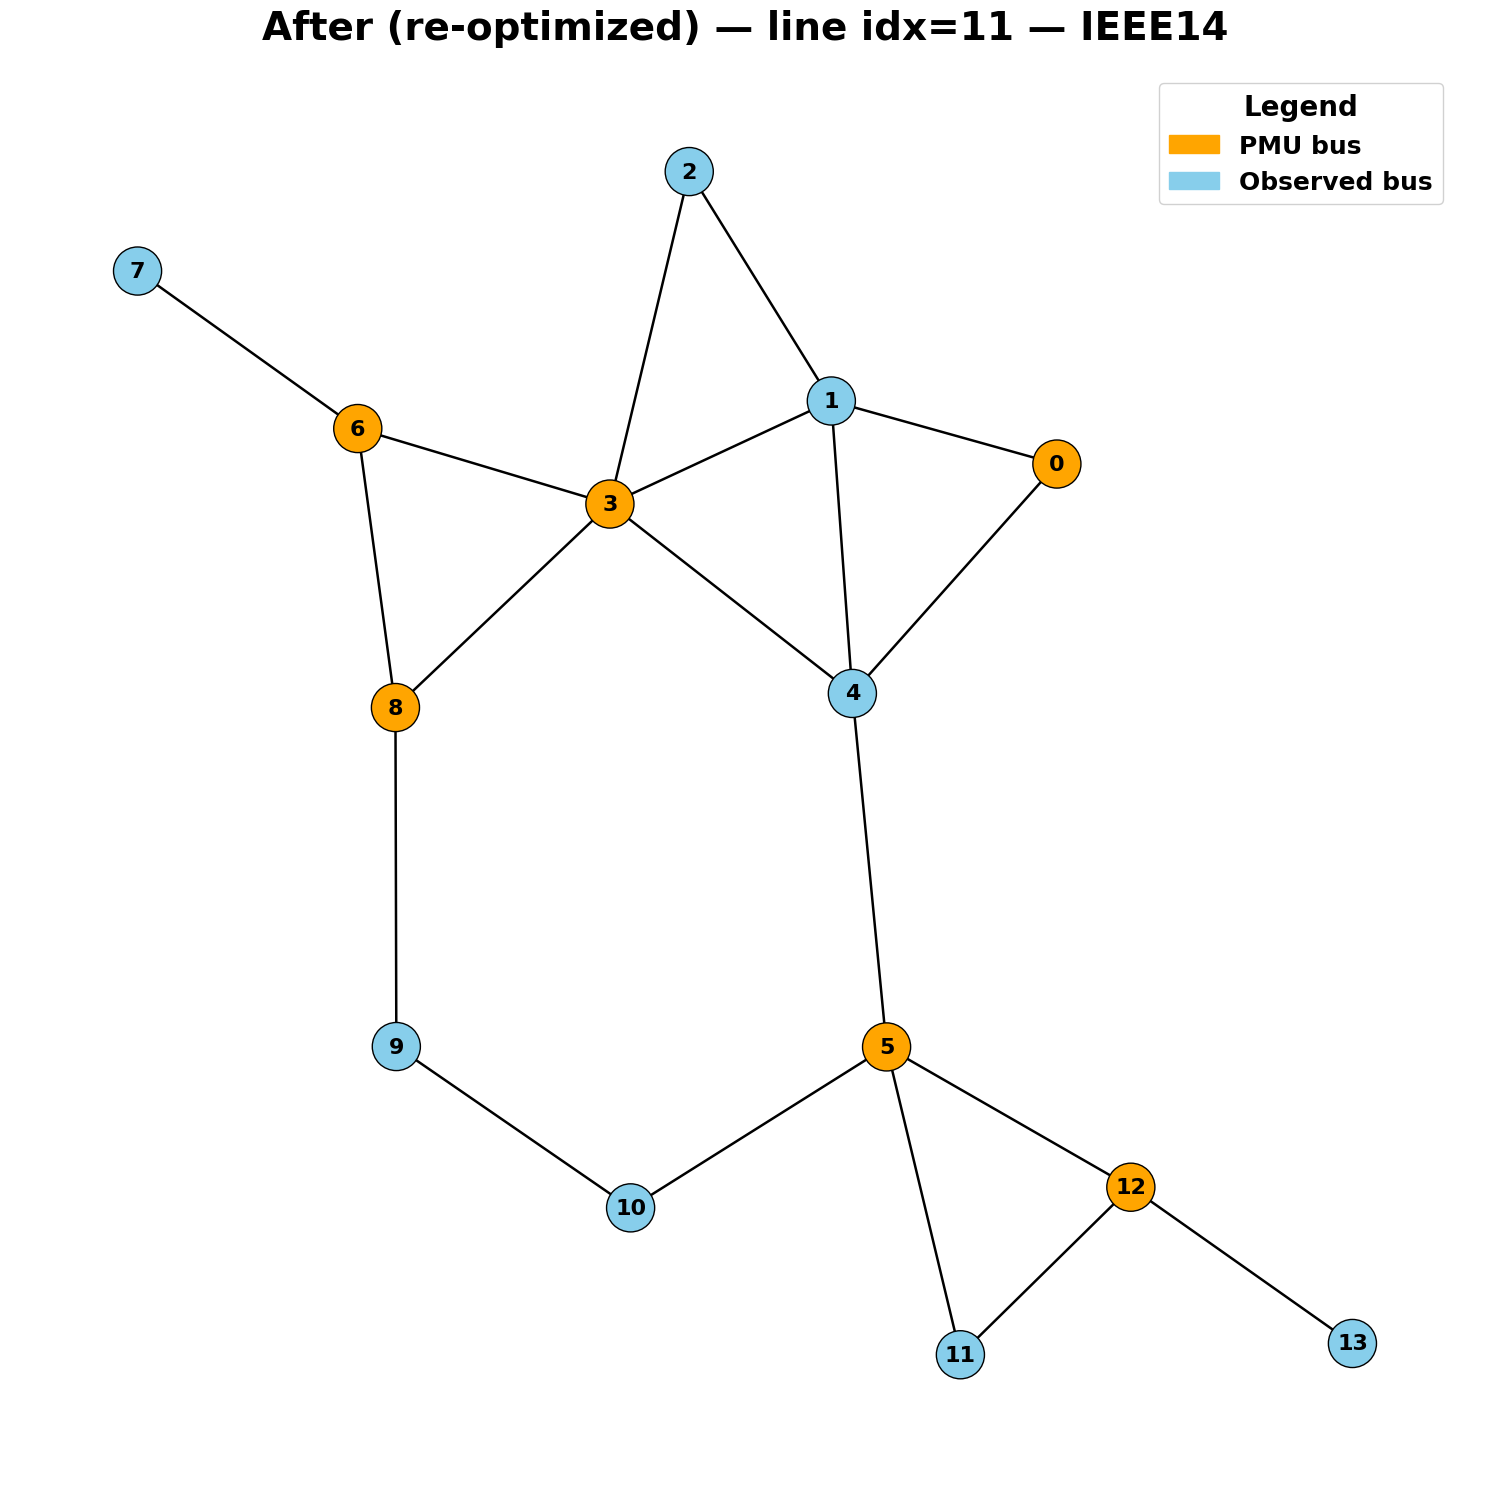

Saved FIG PNG: D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054035_worst2_before_IEEE14_line_9.png
Saved FIG SVG: D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054035_worst2_before_IEEE14_line_9.svg
Running Inkscape for EMF export:
   D:\Programs\inkscape\bin\inkscape.exe D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054035_worst2_before_IEEE14_line_9.svg --export-type=emf --export-filename=D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054035_worst2_before_IEEE14_line_9.emf
Saved FIG EMF (via Inkscape): D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054035_worst2_before_IEEE14_line_9.emf


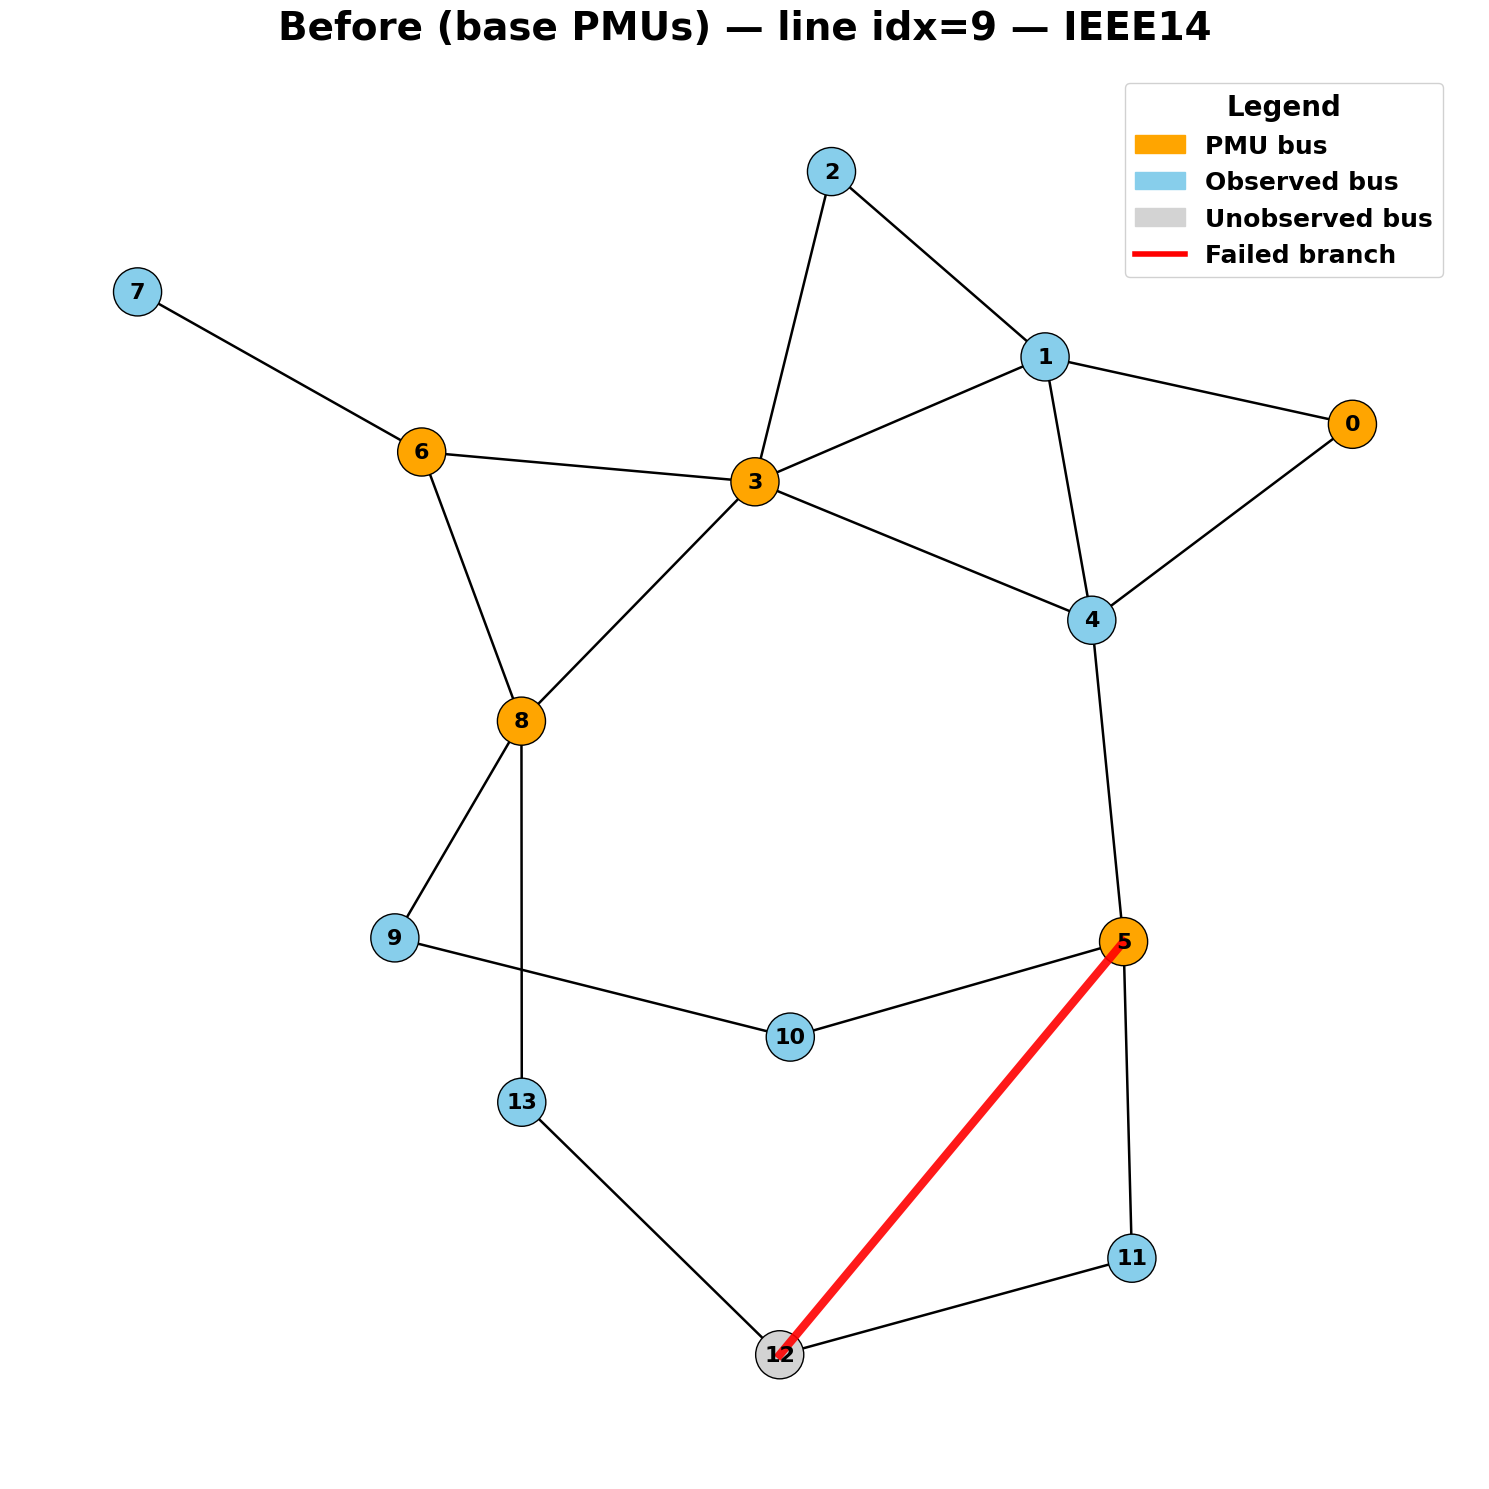

Saved FIG PNG: D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054038_worst2_after_IEEE14_line_9.png
Saved FIG SVG: D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054038_worst2_after_IEEE14_line_9.svg
Running Inkscape for EMF export:
   D:\Programs\inkscape\bin\inkscape.exe D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054038_worst2_after_IEEE14_line_9.svg --export-type=emf --export-filename=D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054038_worst2_after_IEEE14_line_9.emf
Saved FIG EMF (via Inkscape): D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054038_worst2_after_IEEE14_line_9.emf


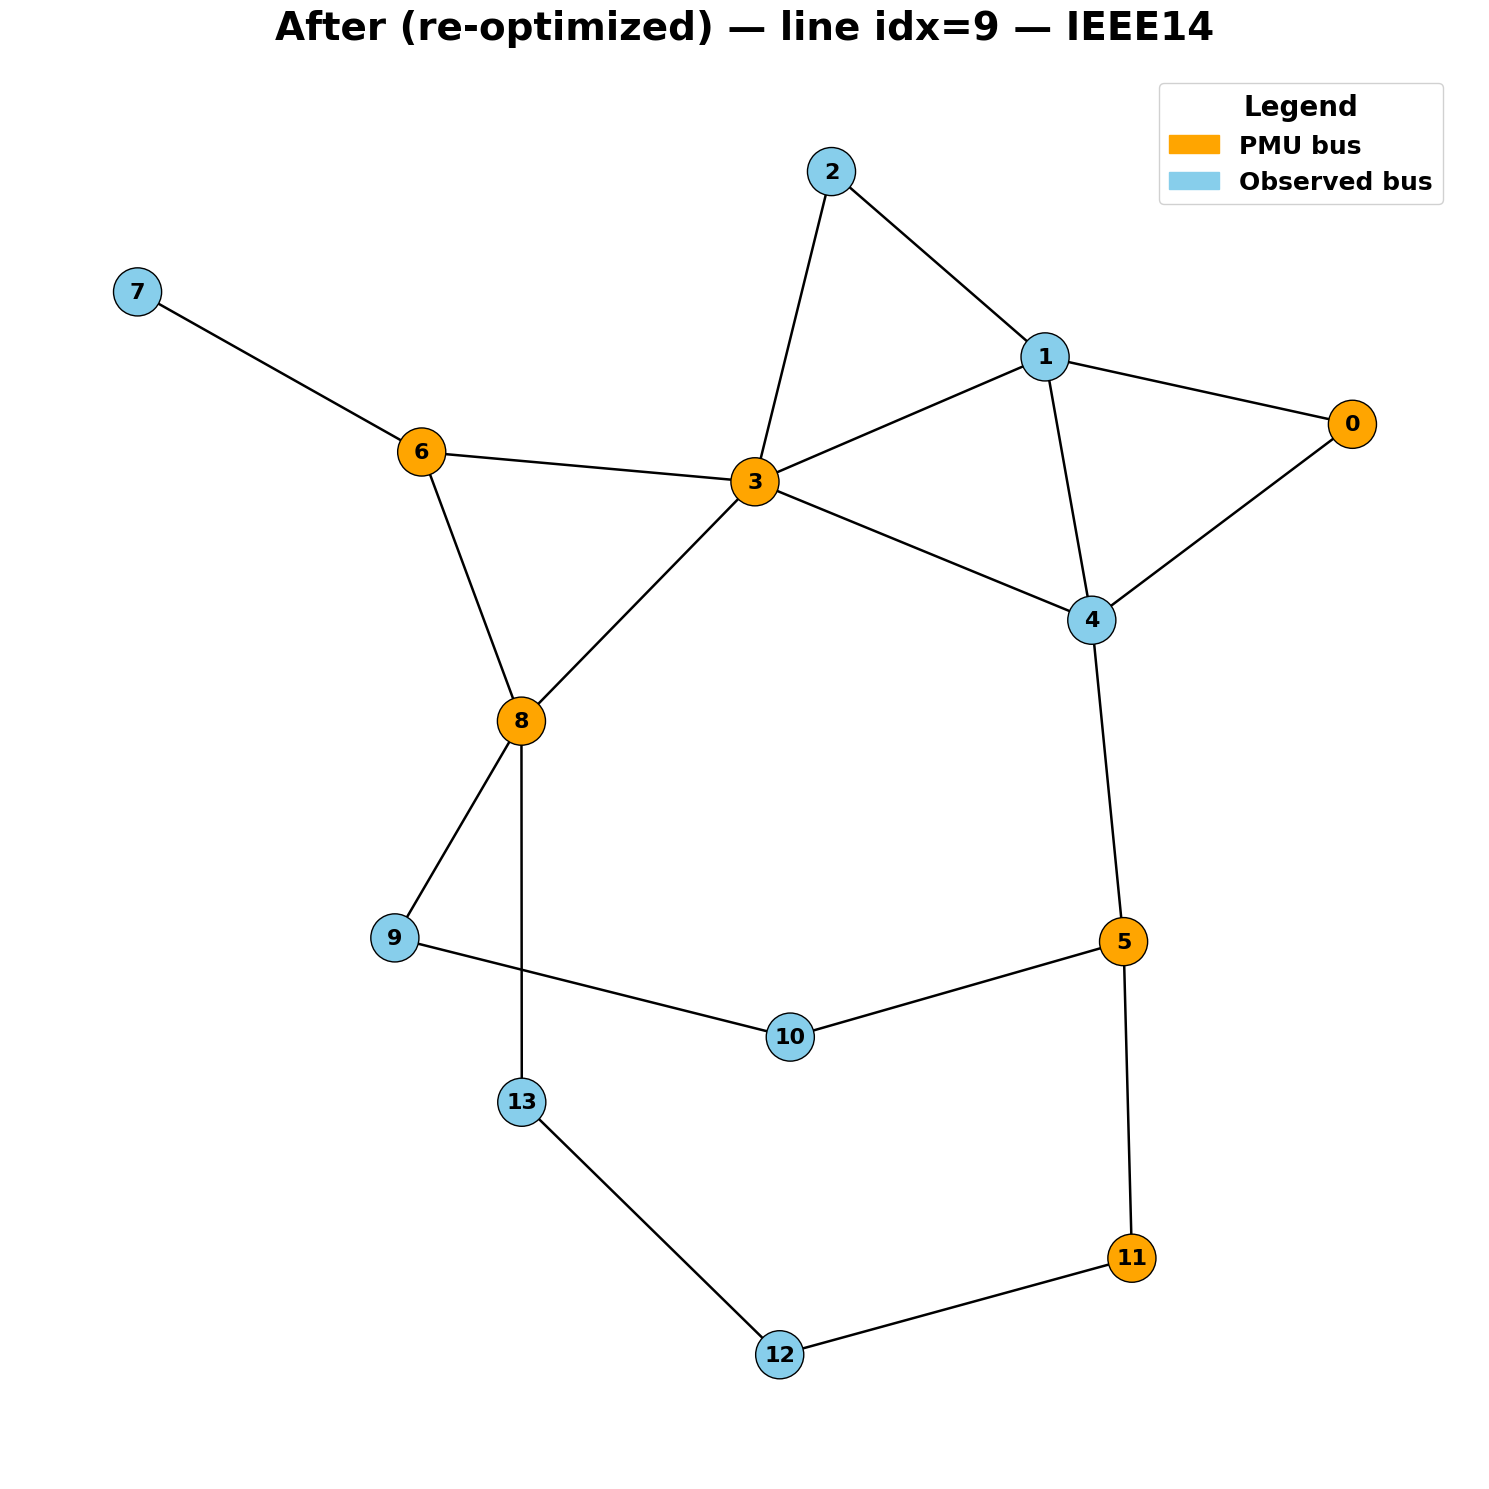

Saved FIG PNG: D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054041_worst3_before_IEEE14_line_10.png
Saved FIG SVG: D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054041_worst3_before_IEEE14_line_10.svg
Running Inkscape for EMF export:
   D:\Programs\inkscape\bin\inkscape.exe D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054041_worst3_before_IEEE14_line_10.svg --export-type=emf --export-filename=D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054041_worst3_before_IEEE14_line_10.emf
Saved FIG EMF (via Inkscape): D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054041_worst3_before_IEEE14_line_10.emf


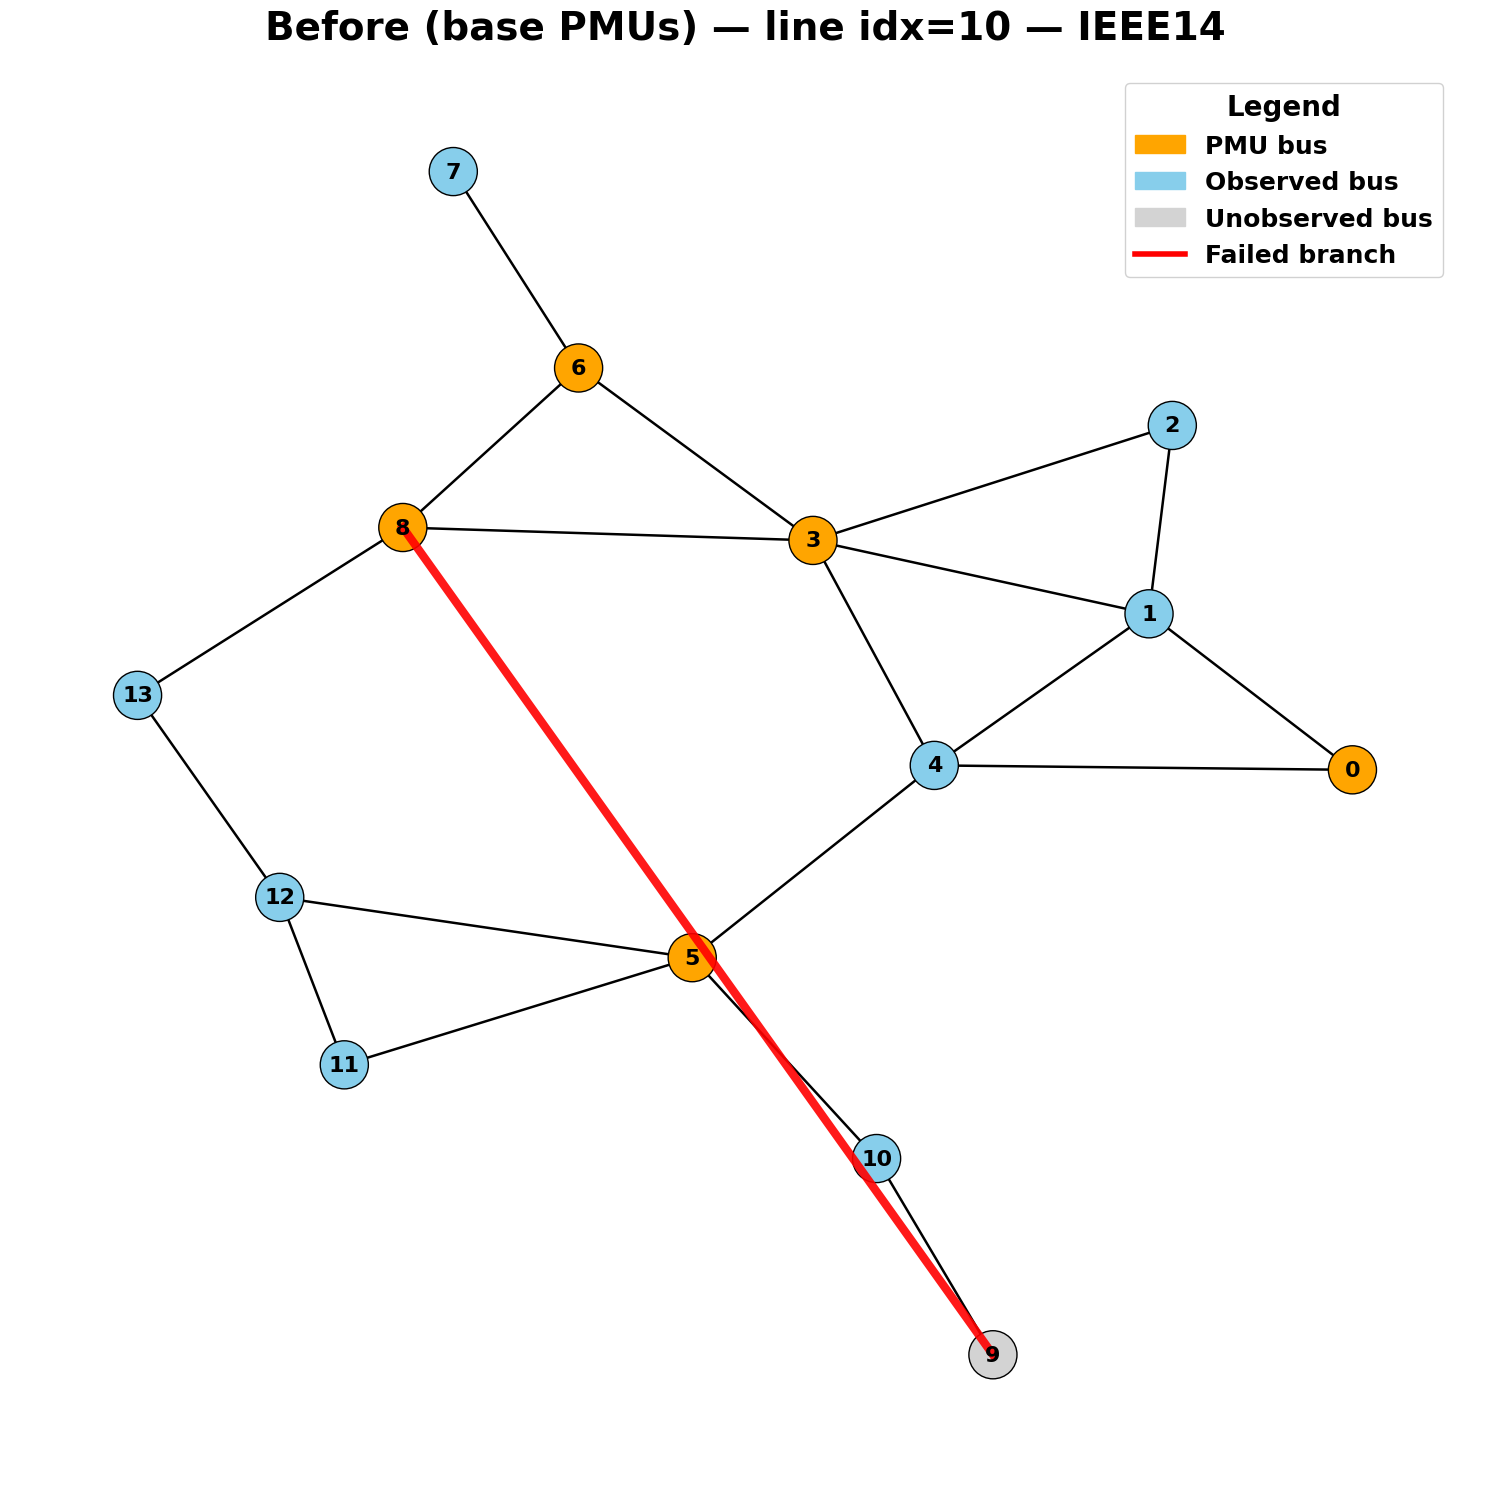

Saved FIG PNG: D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054045_worst3_after_IEEE14_line_10.png
Saved FIG SVG: D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054045_worst3_after_IEEE14_line_10.svg
Running Inkscape for EMF export:
   D:\Programs\inkscape\bin\inkscape.exe D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054045_worst3_after_IEEE14_line_10.svg --export-type=emf --export-filename=D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054045_worst3_after_IEEE14_line_10.emf
Saved FIG EMF (via Inkscape): D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054045_worst3_after_IEEE14_line_10.emf


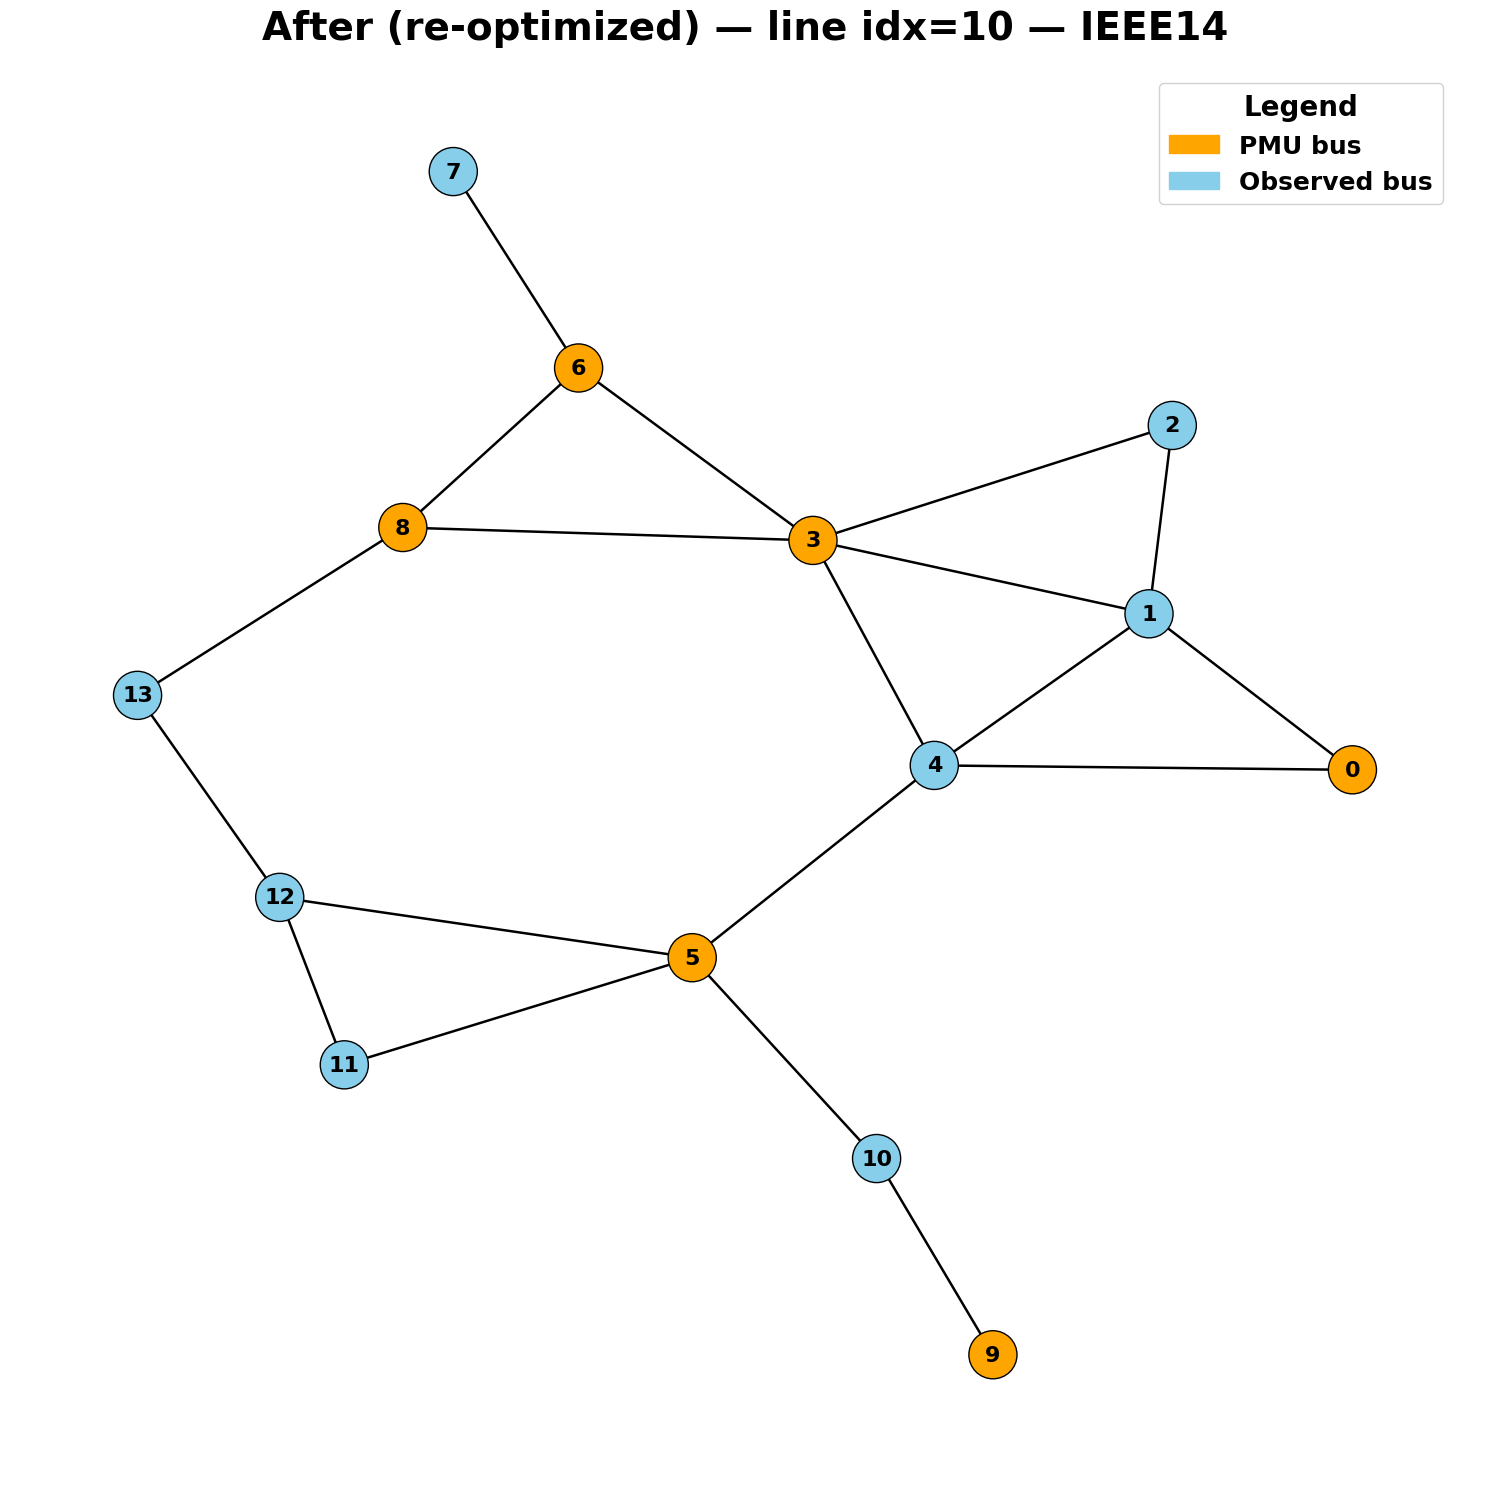

Saved FIG PNG: D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054049_worst4_before_IEEE14_trafo_3.png
Saved FIG SVG: D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054049_worst4_before_IEEE14_trafo_3.svg
Running Inkscape for EMF export:
   D:\Programs\inkscape\bin\inkscape.exe D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054049_worst4_before_IEEE14_trafo_3.svg --export-type=emf --export-filename=D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054049_worst4_before_IEEE14_trafo_3.emf
Saved FIG EMF (via Inkscape): D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054049_worst4_before_IEEE14_trafo_3.emf


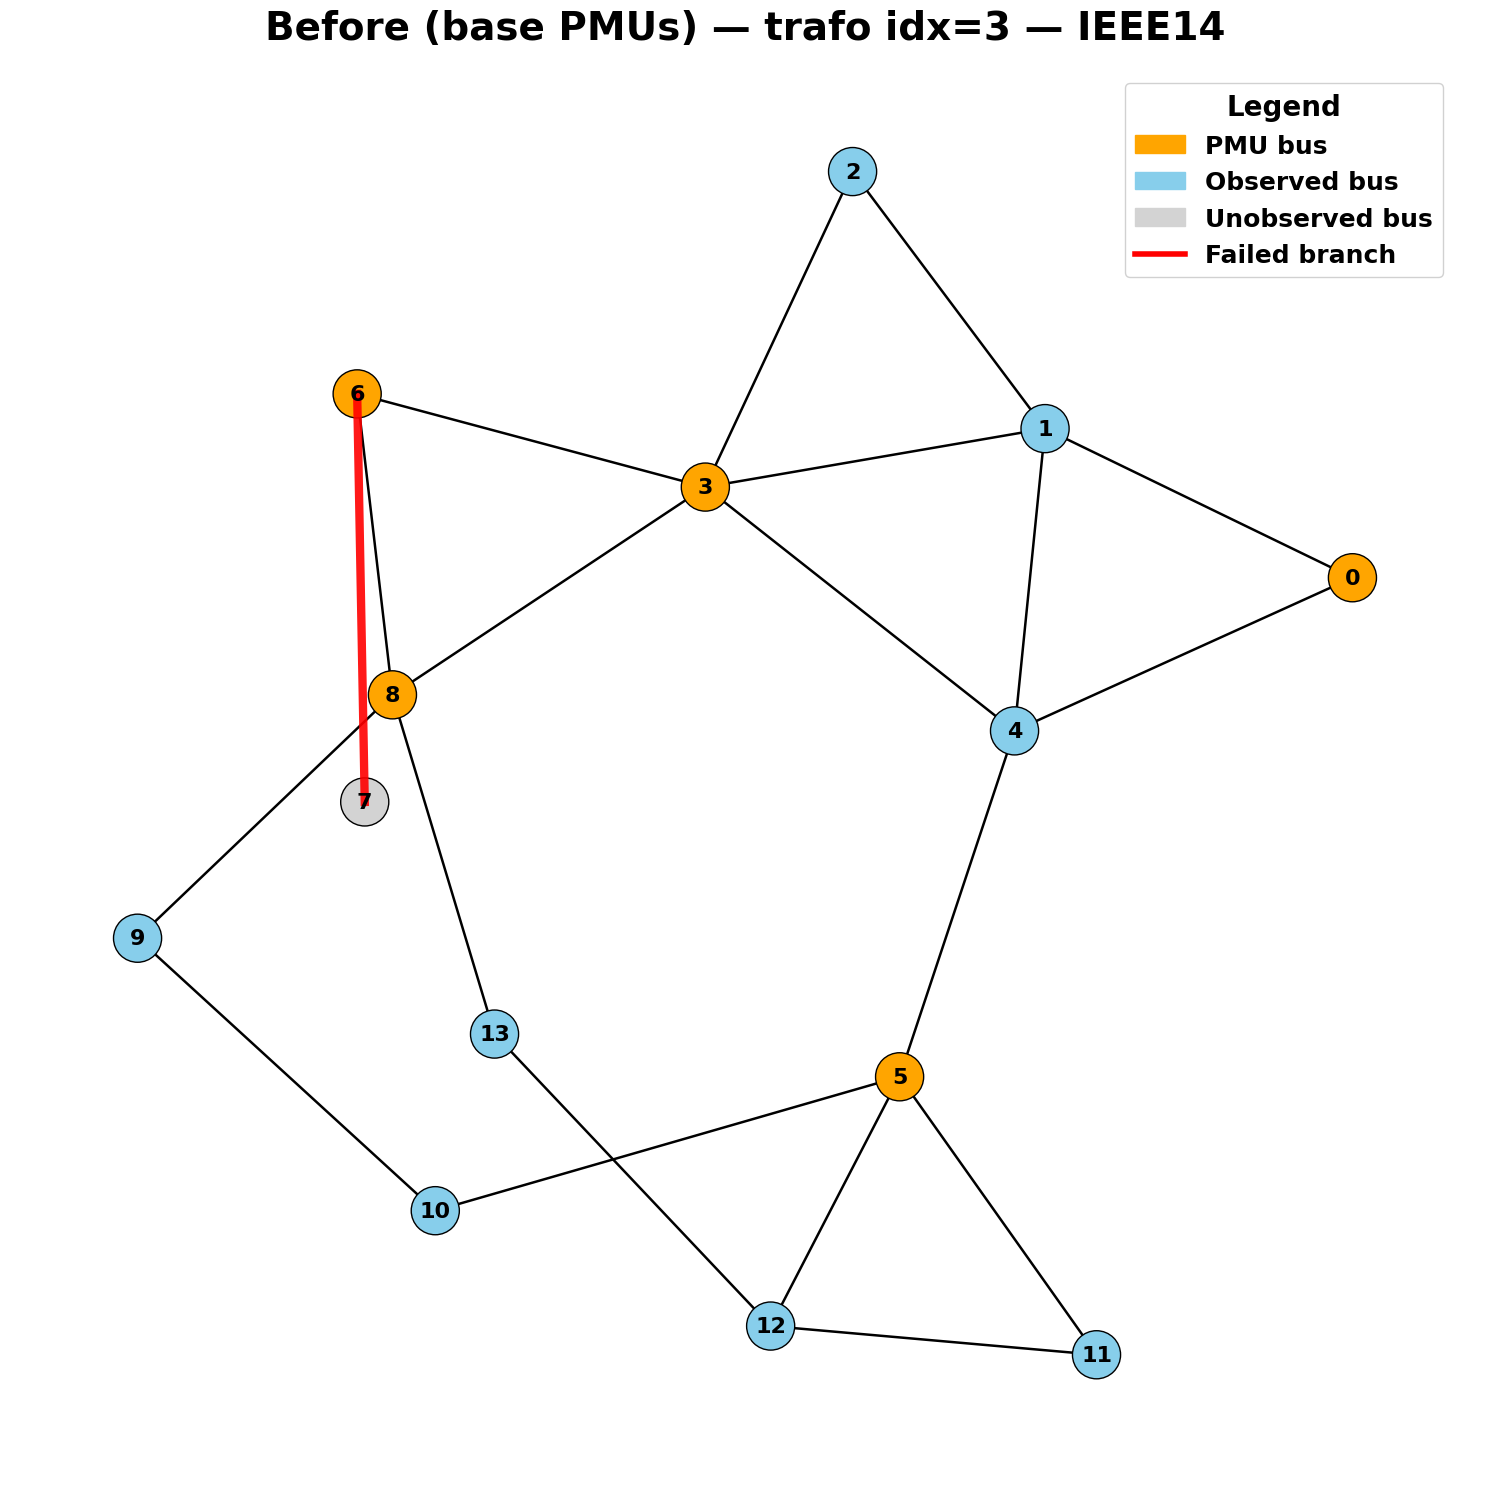

Saved FIG PNG: D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054052_worst4_after_IEEE14_trafo_3.png
Saved FIG SVG: D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054052_worst4_after_IEEE14_trafo_3.svg
Running Inkscape for EMF export:
   D:\Programs\inkscape\bin\inkscape.exe D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054052_worst4_after_IEEE14_trafo_3.svg --export-type=emf --export-filename=D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054052_worst4_after_IEEE14_trafo_3.emf
Saved FIG EMF (via Inkscape): D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054052_worst4_after_IEEE14_trafo_3.emf


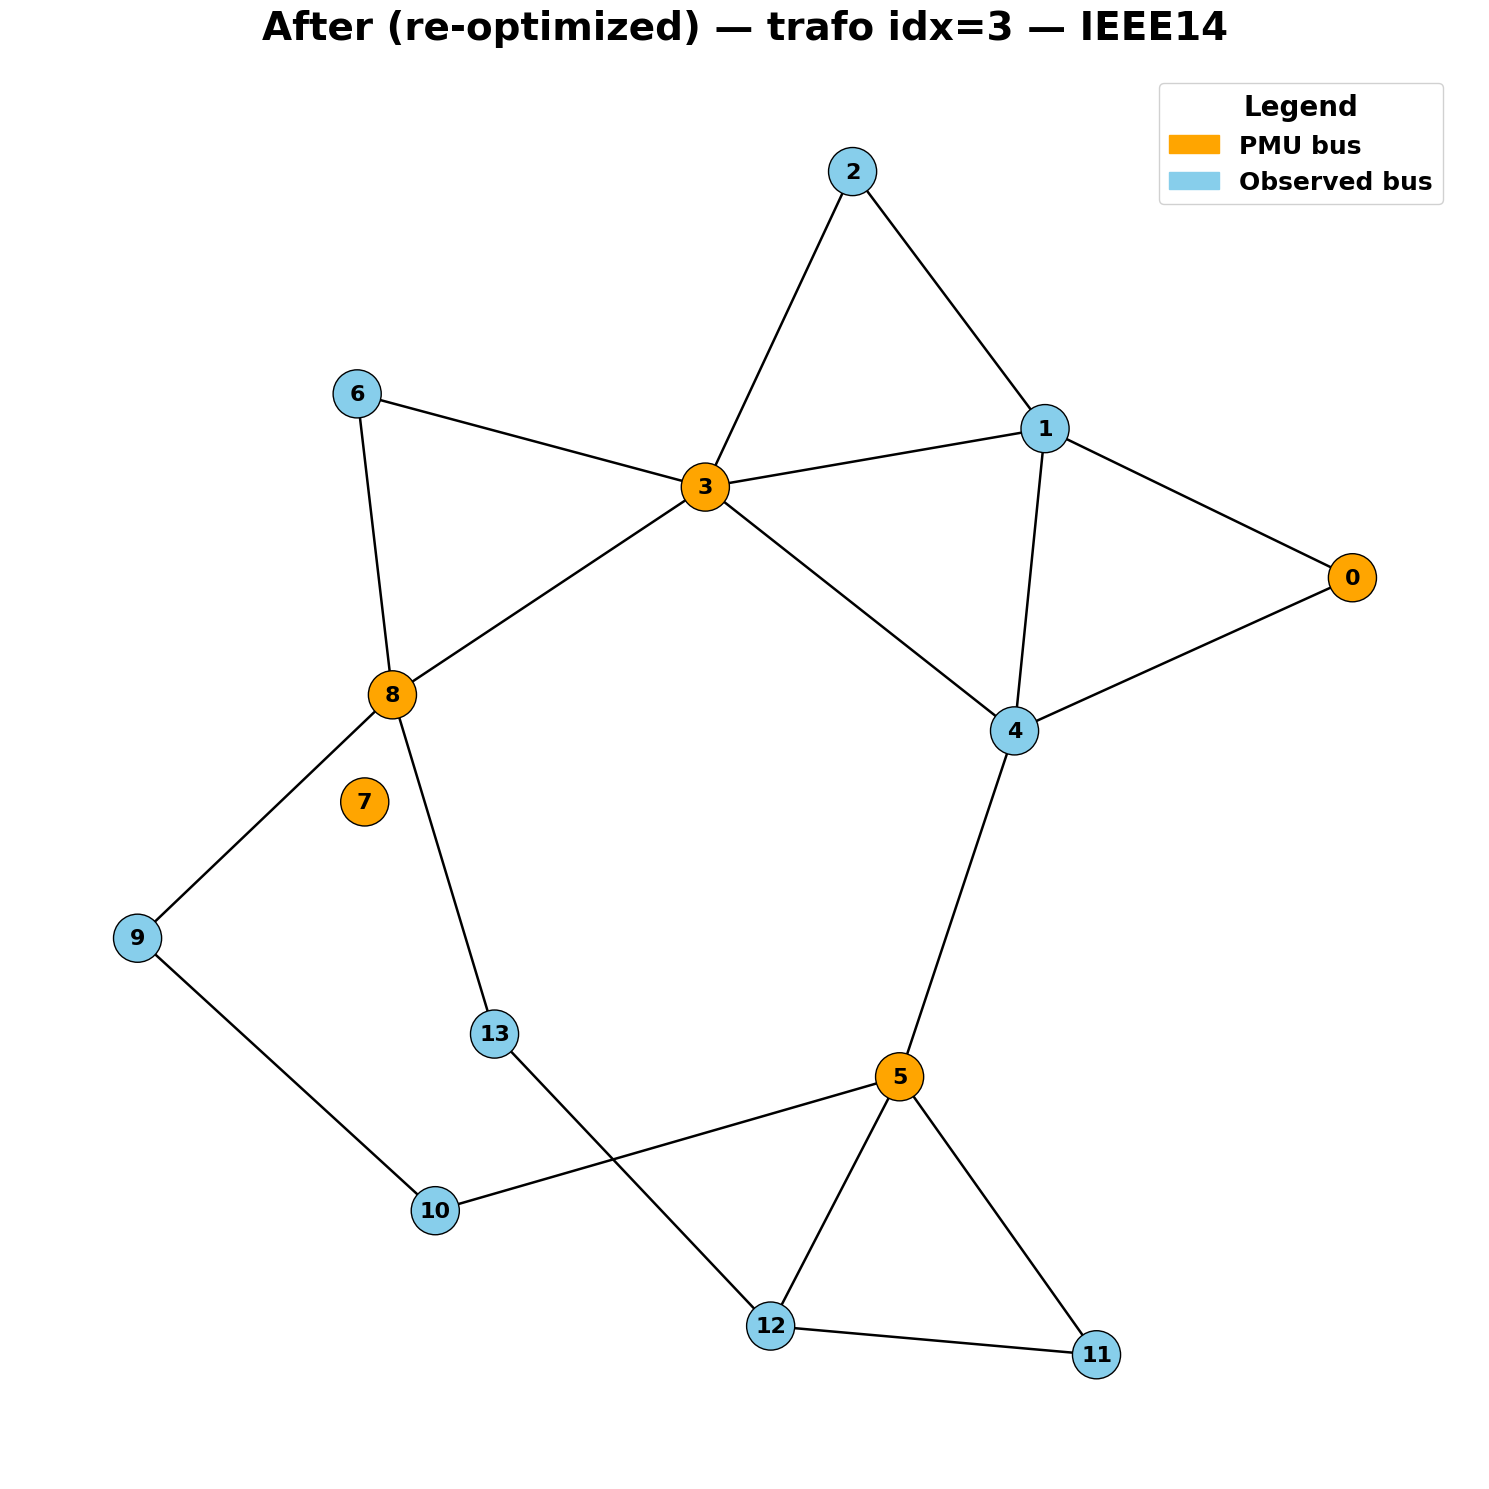

Saved FIG PNG: D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054056_worst5_before_IEEE14_line_8.png
Saved FIG SVG: D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054056_worst5_before_IEEE14_line_8.svg
Running Inkscape for EMF export:
   D:\Programs\inkscape\bin\inkscape.exe D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054056_worst5_before_IEEE14_line_8.svg --export-type=emf --export-filename=D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054056_worst5_before_IEEE14_line_8.emf
Saved FIG EMF (via Inkscape): D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054056_worst5_before_IEEE14_line_8.emf


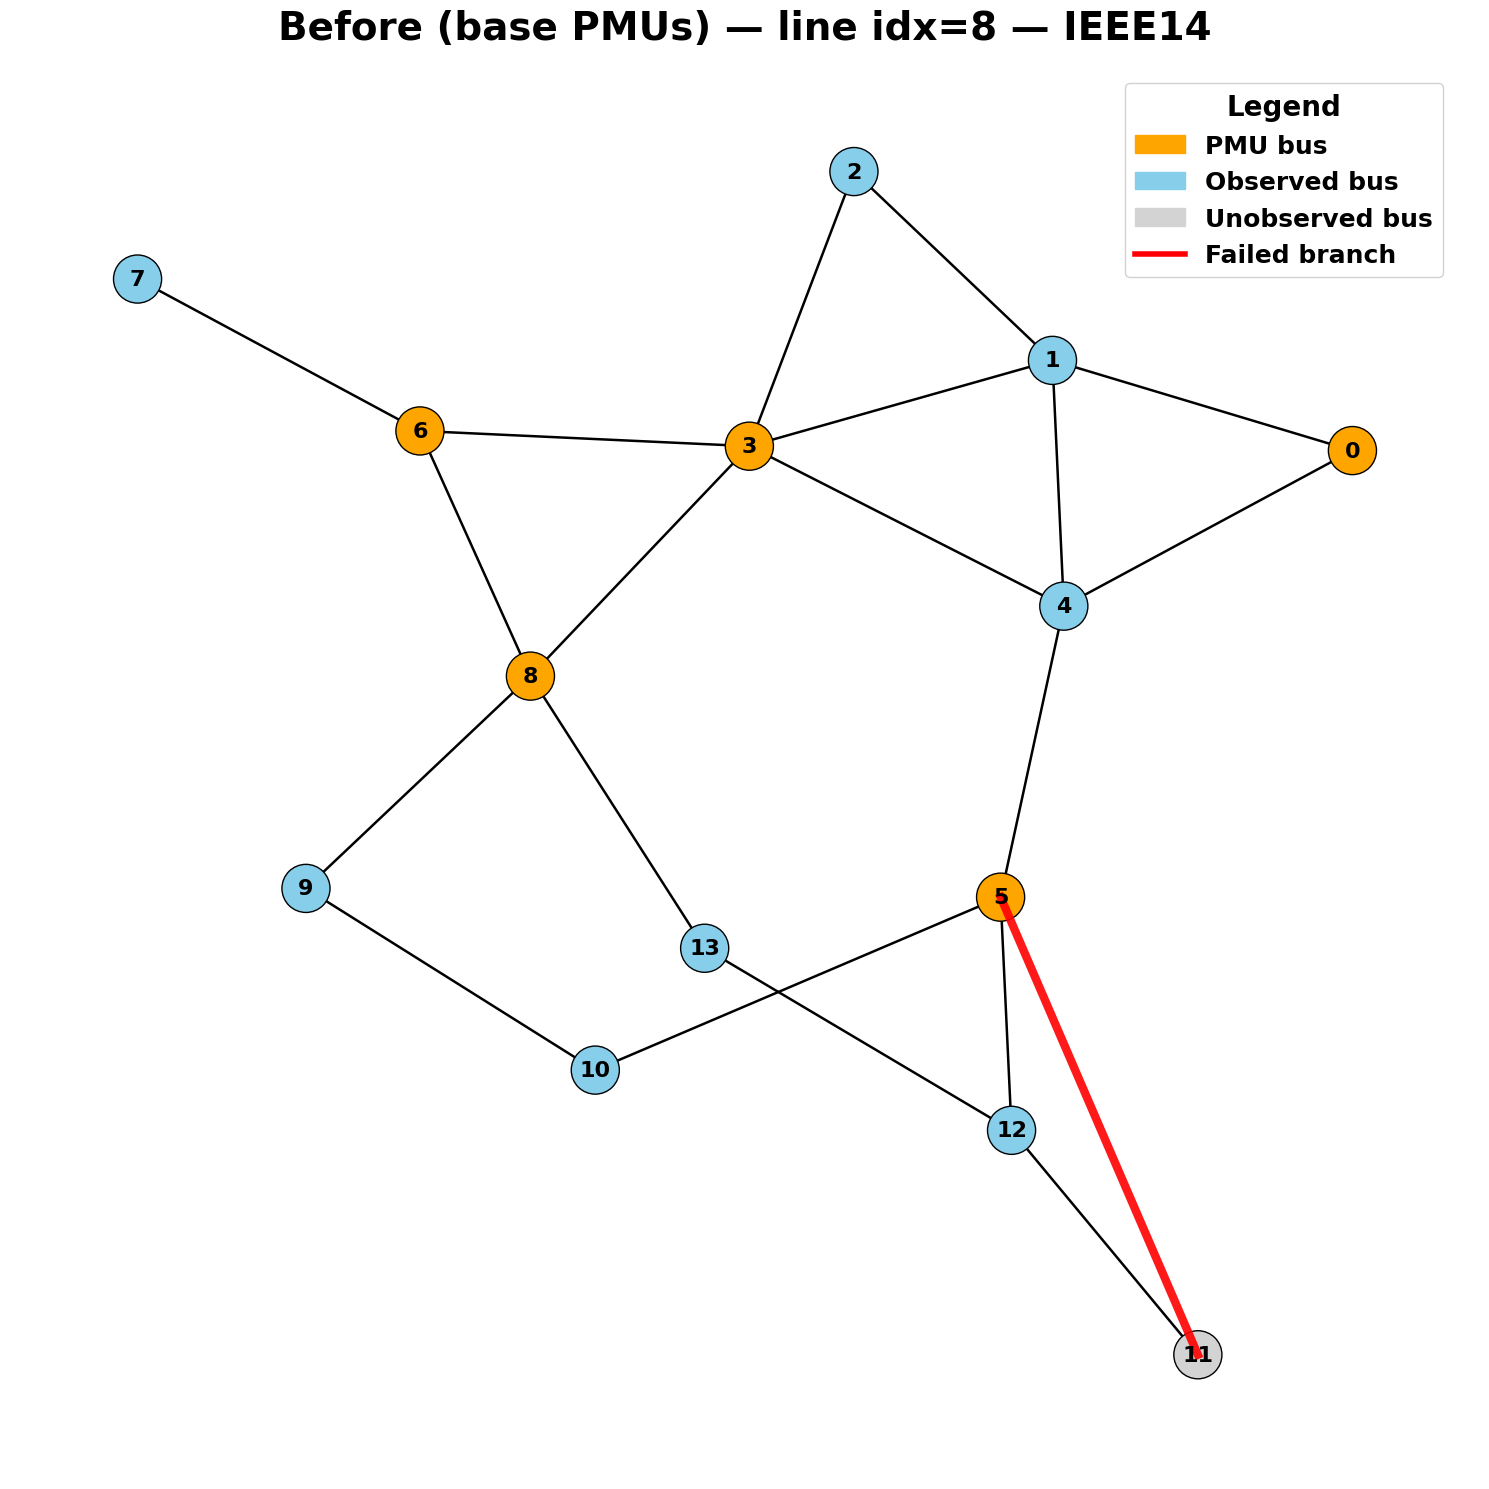

Saved FIG PNG: D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054059_worst5_after_IEEE14_line_8.png
Saved FIG SVG: D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054059_worst5_after_IEEE14_line_8.svg
Running Inkscape for EMF export:
   D:\Programs\inkscape\bin\inkscape.exe D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054059_worst5_after_IEEE14_line_8.svg --export-type=emf --export-filename=D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054059_worst5_after_IEEE14_line_8.emf
Saved FIG EMF (via Inkscape): D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\worst\20251128_054059_worst5_after_IEEE14_line_8.emf


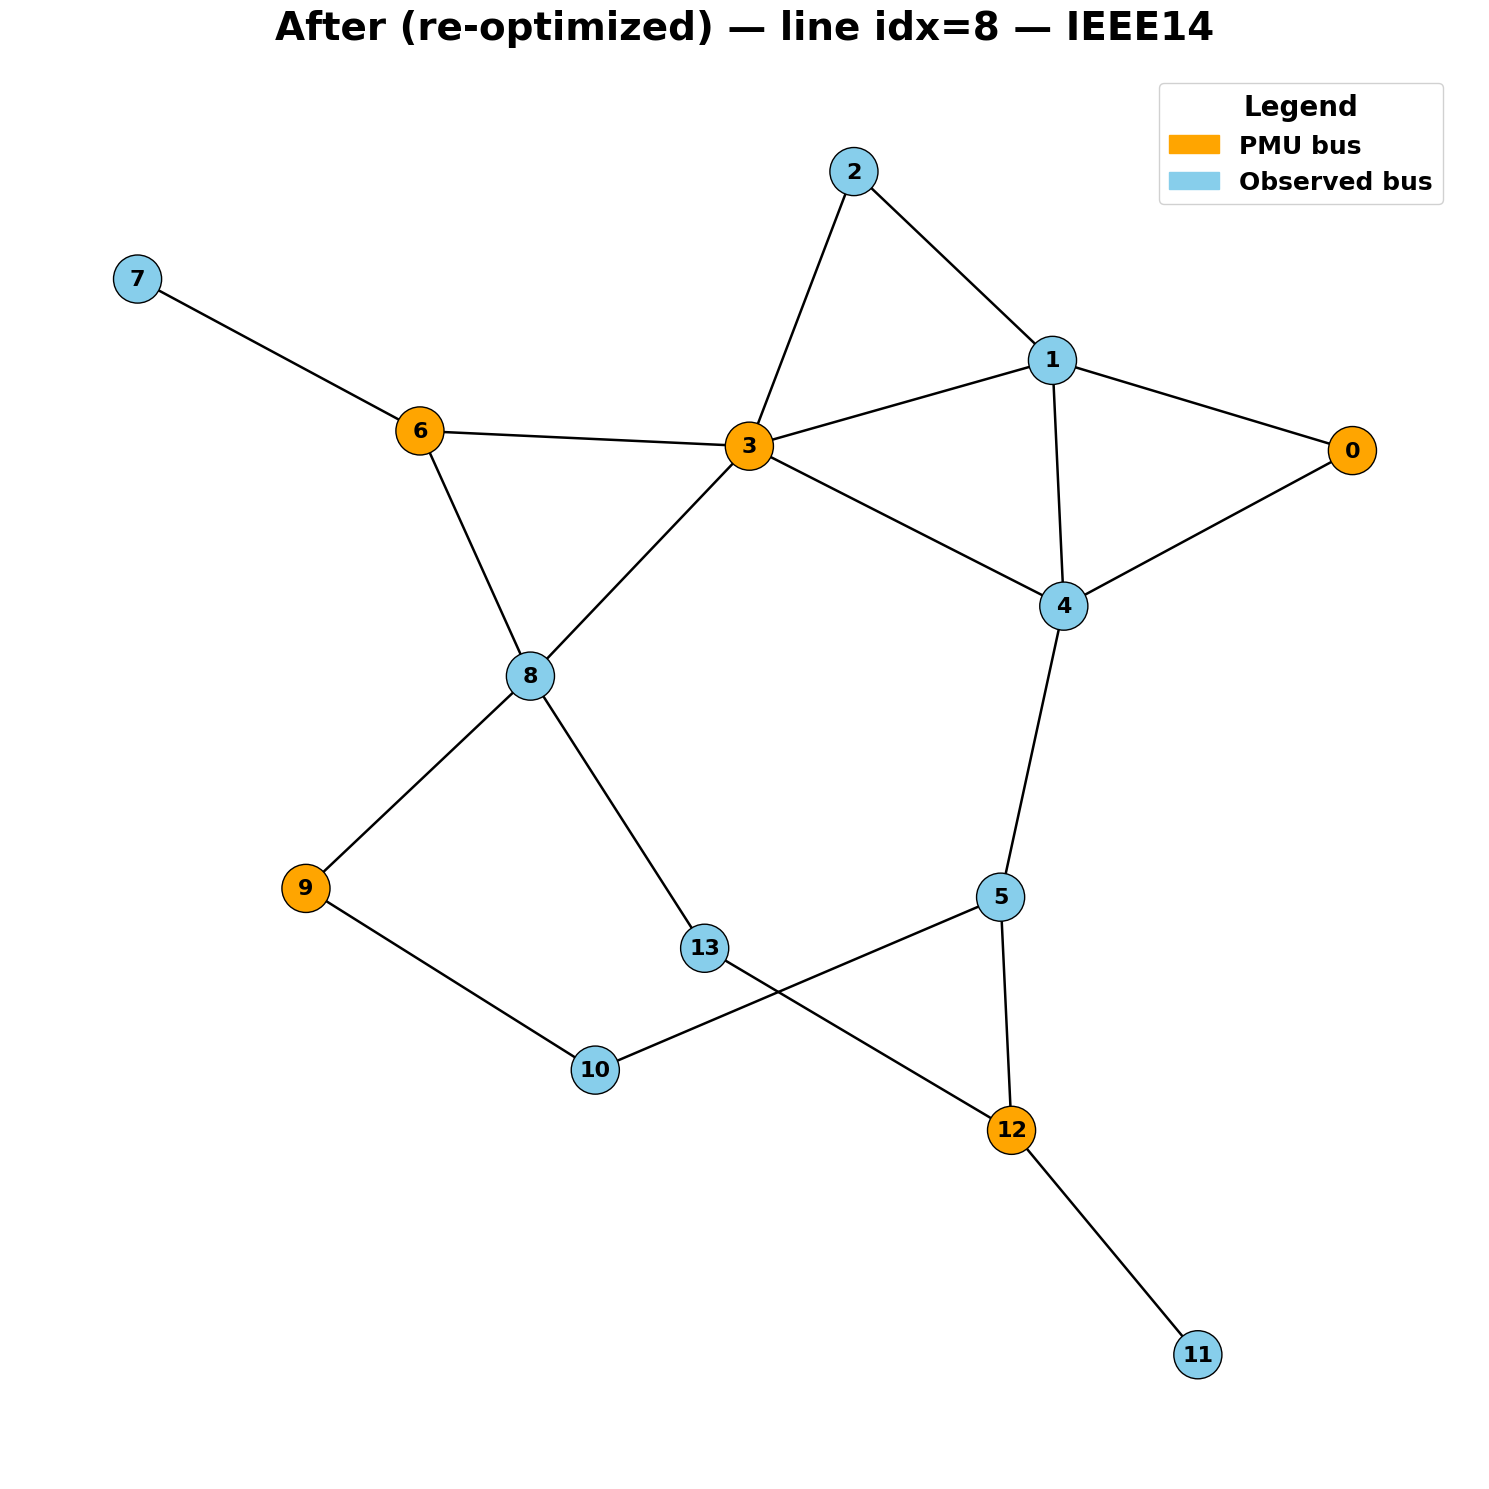

Saved FIG PNG: D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\topk\20251128_054103_topk_outages_IEEE14.png
Saved FIG SVG: D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\topk\20251128_054103_topk_outages_IEEE14.svg
Running Inkscape for EMF export:
   D:\Programs\inkscape\bin\inkscape.exe D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\topk\20251128_054103_topk_outages_IEEE14.svg --export-type=emf --export-filename=D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\topk\20251128_054103_topk_outages_IEEE14.emf
Saved FIG EMF (via Inkscape): D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054024_greedy_n1_14\IEEE14\topk\20251128_054103_topk_outages_IEEE14.emf


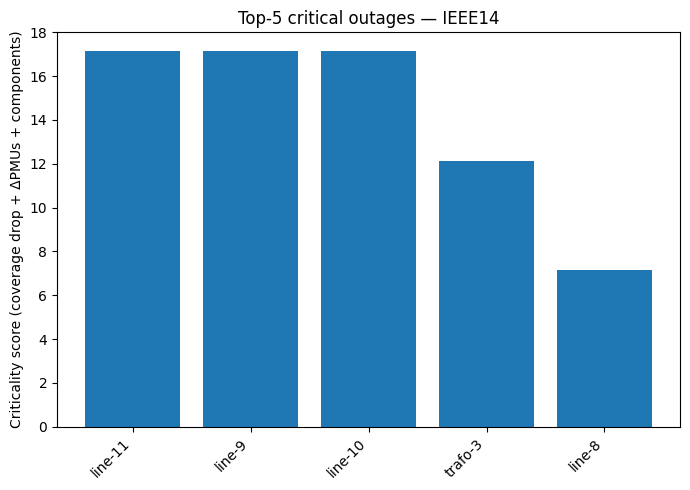

Saved TXT: D:\my_projects\pmu-placement-gnn\results\metrics\RUN_20251128_054024_greedy_n1_14\IEEE14\summary\summary_IEEE14.txt
Saved manifest: D:\my_projects\pmu-placement-gnn\results\metrics\RUN_20251128_054024_greedy_n1_14\IEEE14\manifest\manifest_IEEE14.json
IEEE14 N-1 Run ID: RUN_20251128_054024_greedy_n1_14
Saved CSV: D:\my_projects\pmu-placement-gnn\results\metrics\RUN_20251128_054106_greedy_random_14\IEEE14\baseline\baseline_IEEE14.csv
Saved FIG PNG: D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054106_greedy_random_14\IEEE14\base\20251128_054106_base_IEEE14.png
Saved FIG SVG: D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054106_greedy_random_14\IEEE14\base\20251128_054106_base_IEEE14.svg
Running Inkscape for EMF export:
   D:\Programs\inkscape\bin\inkscape.exe D:\my_projects\pmu-placement-gnn\results\figures\RUN_20251128_054106_greedy_random_14\IEEE14\base\20251128_054106_base_IEEE14.svg --export-type=emf --export-filename=D:\my_projects\pmu-plac

In [10]:
# ============================================
# Run greedy experiment (IEEE14 example)
# ============================================

# Choose system here. For IEEE118 or IEEE30, just change these two lines.
net14 = pn.case14()
system_name_14 = "IEEE14"

run_id_14_n1, manifest_14_n1 = run_suite(
    net14,
    system_name=system_name_14,
    top_k=5,
    preview=True,          # set False to avoid popping all figures
    run_tag="greedy_n1_14",
    fault_mode="n-1"
)
print("IEEE14 N-1 Run ID:", run_id_14_n1)

# If later you want a RANDOM fault dataset as well, you can run:
run_id_14_random, manifest_14_random = run_suite(
    net14,
    system_name=system_name_14,
    top_k=5,
    preview=False,
    run_tag="greedy_random_14",
    fault_mode="random",
    num_random_scenarios=50,   # or 100 if you can
    max_faults_random=3,
)
print("IEEE14 RANDOM Run ID:", run_id_14_random)



In [11]:
# %%
# ============================================
# GNN DATASET BUILDER  (with extra random faults)
# ============================================
GNN_DATA_ROOT = os.path.join(RESULTS_ROOT, "gnn_dataset")

def graph_to_gnn_arrays(G: nx.Graph, net, pmu_list):
    """
    Convert a NetworkX graph + pandapower net + PMU list
    into numpy arrays suitable for GNN training.
    """
    # --- Node indexing: map original bus IDs -> [0..N-1]
    buses = sorted(G.nodes())  # original bus IDs
    N = len(buses)
    bus_to_idx = {b: i for i, b in enumerate(buses)}

    # --- Some pandapower-based info for node features
    load_buses = set(net.load["bus"].astype(int).tolist()) if len(net.load) > 0 else set()
    gen_buses  = set(net.gen["bus"].astype(int).tolist())  if len(net.gen)  > 0 else set()
    ext_buses  = set(net.ext_grid["bus"].astype(int).tolist()) if len(net.ext_grid) > 0 else set()

    # Node features: [voltage_level, degree, has_load, has_gen, has_ext_grid]
    F_node = 5
    x = np.zeros((N, F_node), dtype=np.float32)
    for b in buses:
        i = bus_to_idx[b]
        voltage = G.nodes[b].get("voltage_level", 0.0)
        degree  = float(G.degree[b])
        has_load = 1.0 if b in load_buses else 0.0
        has_gen  = 1.0 if b in gen_buses else 0.0
        has_ext  = 1.0 if b in ext_buses else 0.0

        x[i, 0] = voltage
        x[i, 1] = degree
        x[i, 2] = has_load
        x[i, 3] = has_gen
        x[i, 4] = has_ext

    # --- Edge index + edge features
    E = G.number_of_edges()
    edge_index = np.zeros((2, E), dtype=np.int64)

    # Edge features: [length_km, r_ohm_per_km, sn_mva, impedance, is_line, is_trafo]
    F_edge = 6
    edge_attr = np.zeros((E, F_edge), dtype=np.float32)

    for e_idx, (u, v, data) in enumerate(G.edges(data=True)):
        ui = bus_to_idx[u]
        vi = bus_to_idx[v]
        edge_index[0, e_idx] = ui
        edge_index[1, e_idx] = vi

        kind = data.get("kind", "line")
        if kind == "line":
            edge_attr[e_idx, 0] = float(data.get("length", 0.0))
            edge_attr[e_idx, 1] = float(data.get("resistance", 0.0))
            edge_attr[e_idx, 4] = 1.0  # is_line
        elif kind == "trafo":
            edge_attr[e_idx, 2] = float(data.get("sn_mva", 0.0))
            edge_attr[e_idx, 3] = float(data.get("impedance", 0.0))
            edge_attr[e_idx, 5] = 1.0  # is_trafo

    # --- Node labels y (PMU placement)
    y = np.zeros((N,), dtype=np.int64)
    pmu_set = set(int(p) for p in pmu_list)
    for b in buses:
        if b in pmu_set:
            y[bus_to_idx[b]] = 1

    bus_ids = np.array(buses, dtype=np.int64)

    return x, edge_index, edge_attr, y, bus_ids


def build_gnn_dataset_from_manifest(
    net,
    manifest,
    max_fault_samples=None,
    extra_random_faults_for_gnn=0,   # <--- NEW: add extra random multi-fault graphs
    max_faults_random=3,
):
    """
    Build a full GNN dataset (NPZ files + index.csv + dataset_summary.csv) for one system/run,
    using:
      - intact network (baseline PMUs)
      - all faulted scenarios from robustness CSV (re-optimized PMUs)
      - OPTIONAL: extra random multi-fault graphs for GNN training only
    """
    system_name = manifest["system"]
    run_id      = manifest["run_id"]

    # Where to save GNN data
    out_root    = os.path.join(GNN_DATA_ROOT, run_id, system_name)
    samples_dir = os.path.join(out_root, "samples")
    os.makedirs(samples_dir, exist_ok=True)
    print(f"GNN dataset root: {out_root}")

    # --- Load baseline (intact) PMUs
    base_csv = manifest["artifacts"]["baseline_csv"]
    df_base  = pd.read_csv(base_csv)
    base_pmus = json.loads(df_base["pmus"].iloc[0])

    # Build intact graph
    G_intact = build_graph(net)
    x, edge_index, edge_attr, y, bus_ids = graph_to_gnn_arrays(G_intact, net, base_pmus)

    # Graph-level labels for intact graph (coverage, #PMUs)
    base_cov   = float(df_base["coverage_%"].iloc[0])
    base_npmus = int(df_base["num_pmus"].iloc[0])
    graph_y_intact = np.array([base_cov, base_npmus], dtype=np.float32)

    # Save intact sample
    index_rows = []
    intact_id  = "intact"
    intact_path = os.path.join(samples_dir, f"{intact_id}.npz")
    np.savez(
        intact_path,
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=y,
        bus_ids=bus_ids,
        graph_y=graph_y_intact,
        scenario_type=np.array(["intact"]),
    )
    index_rows.append({
        "sample_id": intact_id,
        "file": os.path.relpath(intact_path, out_root),
        "scenario_type": "intact",
        "kind": "",
        "idx": "",
        "failed_u": "",
        "failed_v": "",
        "coverage_fixed_%": base_cov,
        "coverage_reopt_%": base_cov,
        "delta_pmus": 0.0,
        "components": nx.number_connected_components(G_intact),
    })
    print(f"Saved intact sample to {intact_path}")

    # --- Load robustness CSV (faulted scenarios)
    rob_csv = manifest["artifacts"]["robustness_csv"]
    df_rob  = pd.read_csv(rob_csv)
    print(f"Loaded {len(df_rob)} faulted scenarios from {rob_csv}")

    original_fault_count = len(df_rob)

    if max_fault_samples is not None:
        df_rob = df_rob.head(max_fault_samples)
        print(f"Using only first {len(df_rob)} fault samples (max_fault_samples={max_fault_samples})")

    # --- Build a sample for each faulted scenario (from robustness CSV)
    for row_i, row in df_rob.iterrows():
        kind = row["kind"]
        idx  = int(row["idx"])

        pmus_reopt = json.loads(row["pmus_reopt_list"])  # labels for this faulted topology

        # Build faulted net and graph
        net_out = deactivate(net, kind, idx)
        G_out   = build_graph(net_out)

        x, edge_index, edge_attr, y, bus_ids = graph_to_gnn_arrays(G_out, net_out, pmus_reopt)

        # Graph-level labels / metrics from robustness CSV
        cov_fixed  = float(row["coverage_fixed_%"])
        cov_reopt  = float(row["coverage_reopt_%"])
        delta_pmus = float(row["delta_pmus"])
        comps      = int(row["components"])
        failed_u   = int(row["failed_u"])
        failed_v   = int(row["failed_v"])

        graph_y = np.array([cov_fixed, cov_reopt, delta_pmus, comps], dtype=np.float32)

        sample_id = f"{kind}_{idx}_{row_i}"  # ensure uniqueness
        sample_path = os.path.join(samples_dir, f"{sample_id}.npz")

        np.savez(
            sample_path,
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr,
            y=y,
            bus_ids=bus_ids,
            graph_y=graph_y,
            scenario_type=np.array(["faulted"]),
        )

        index_rows.append({
            "sample_id": sample_id,
            "file": os.path.relpath(sample_path, out_root),
            "scenario_type": "faulted",
            "kind": kind,
            "idx": idx,
            "failed_u": failed_u,
            "failed_v": failed_v,
            "coverage_fixed_%": cov_fixed,
            "coverage_reopt_%": cov_reopt,
            "delta_pmus": delta_pmus,
            "components": comps,
        })

    # --- EXTRA RANDOM MULTI-FAULT GRAPHS (for GNN training only)
    if extra_random_faults_for_gnn and extra_random_faults_for_gnn > 0:
        print(f"Adding {extra_random_faults_for_gnn} extra random-fault graphs for GNN training...")
        for j in range(extra_random_faults_for_gnn):
            net_rand = random_fault_simulation(net, max_faults=max_faults_random)
            G_rand   = build_graph(net_rand)

            pmus_rand = greedy_pmu_placement(G_rand)

            x, edge_index, edge_attr, y, bus_ids = graph_to_gnn_arrays(G_rand, net_rand, pmus_rand)

            cov_rand = 100.0 * len(observed_nodes(G_rand, pmus_rand)) / len(G_rand.nodes())
            comps_rand = nx.number_connected_components(G_rand)

            # here coverage_fixed_ == coverage_reopt_ (they are the same greedy PMU set)
            graph_y = np.array([cov_rand, cov_rand, 0.0, comps_rand], dtype=np.float32)

            sample_id  = f"rand_extra_{j}"
            sample_path = os.path.join(samples_dir, f"{sample_id}.npz")

            np.savez(
                sample_path,
                x=x,
                edge_index=edge_index,
                edge_attr=edge_attr,
                y=y,
                bus_ids=bus_ids,
                graph_y=graph_y,
                scenario_type=np.array(["faulted"]),
            )

            index_rows.append({
                "sample_id": sample_id,
                "file": os.path.relpath(sample_path, out_root),
                "scenario_type": "faulted",
                "kind": "random_multi",
                "idx": -1,
                "failed_u": "",
                "failed_v": "",
                "coverage_fixed_%": cov_rand,
                "coverage_reopt_%": cov_rand,
                "delta_pmus": 0.0,
                "components": comps_rand,
            })

    # --- Save index CSV
    df_index = pd.DataFrame(index_rows)
    index_path = os.path.join(out_root, "index.csv")
    df_index.to_csv(index_path, index=False)
    print(f"Saved dataset index: {index_path}")
    print(f"Total samples: {len(df_index)}")

    # --- Dataset summary CSV (for paper tables)
    num_intact  = (df_index["scenario_type"] == "intact").sum()
    num_faulted = (df_index["scenario_type"] == "faulted").sum()
    num_total   = len(df_index)

    df_dataset_summary = pd.DataFrame([{
        "run_id": run_id,
        "system": system_name,
        "num_buses": G_intact.number_of_nodes(),
        "num_lines": len(net.line),
        "num_trafos": len(net.trafo),
        "num_intact_graphs": int(num_intact),
        "num_faulted_graphs": int(num_faulted),
        "num_total_graphs": int(num_total),
        "original_fault_scenarios_in_robustness_csv": int(original_fault_count),
        "max_fault_samples_used": int(max_fault_samples) if max_fault_samples is not None else -1,
        "extra_random_faults_for_gnn": int(extra_random_faults_for_gnn),
        "max_faults_random_for_gnn": int(max_faults_random),
    }])
    dataset_summary_path = os.path.join(out_root, "dataset_summary.csv")
    df_dataset_summary.to_csv(dataset_summary_path, index=False)
    print(f"Saved dataset summary: {dataset_summary_path}")

    return out_root, index_path, dataset_summary_path


In [12]:
# ============================================
# Build GNN dataset for IEEE14 (N-1 run)
# ============================================

net_for_gnn_14 = net14  # same pandapower net as used in run_suite

out_root_14_n1, index_path_14_n1, ds_sum_14_n1 = build_gnn_dataset_from_manifest(
    net_for_gnn_14,
    manifest_14_n1,
    max_fault_samples=None   # or e.g. 200 to limit number of faults
)
print("GNN dataset for IEEE14 N-1 stored at:", out_root_14_n1)
print("Index file:", index_path_14_n1)
print("Dataset summary file:", ds_sum_14_n1)

# GNN dataset for IEEE14 RANDOM run
net_for_gnn_14 = net14  # same pandapower net

out_root_14_random, index_path_14_random, ds_sum_14_random = build_gnn_dataset_from_manifest(
    net_for_gnn_14,
    manifest_14_random,
    max_fault_samples=None   # or e.g. 500 to cap
)

print("GNN dataset for IEEE14 RANDOM stored at:", out_root_14_random)
print("Index file:", index_path_14_random)
print("Dataset summary file:", ds_sum_14_random)



GNN dataset root: D:\my_projects\pmu-placement-gnn\results\gnn_dataset\RUN_20251128_054024_greedy_n1_14\IEEE14
Saved intact sample to D:\my_projects\pmu-placement-gnn\results\gnn_dataset\RUN_20251128_054024_greedy_n1_14\IEEE14\samples\intact.npz
Loaded 20 faulted scenarios from D:\my_projects\pmu-placement-gnn\results\metrics\RUN_20251128_054024_greedy_n1_14\IEEE14\robustness\robustness_IEEE14.csv
Saved dataset index: D:\my_projects\pmu-placement-gnn\results\gnn_dataset\RUN_20251128_054024_greedy_n1_14\IEEE14\index.csv
Total samples: 21
Saved dataset summary: D:\my_projects\pmu-placement-gnn\results\gnn_dataset\RUN_20251128_054024_greedy_n1_14\IEEE14\dataset_summary.csv
GNN dataset for IEEE14 N-1 stored at: D:\my_projects\pmu-placement-gnn\results\gnn_dataset\RUN_20251128_054024_greedy_n1_14\IEEE14
Index file: D:\my_projects\pmu-placement-gnn\results\gnn_dataset\RUN_20251128_054024_greedy_n1_14\IEEE14\index.csv
Dataset summary file: D:\my_projects\pmu-placement-gnn\results\gnn_dataset\

In [13]:
# ============================================
# Cross-run critical line aggregation (optional)
# ============================================
def aggregate_critical_lines_across_runs(base_metric_dir=BASE_METRIC_DIR):
    """
    Scan all runs and systems under BASE_METRIC_DIR,
    load every critical_lines_*.csv, and merge them into a single big table.
    Useful for global 'critical line' analysis across multiple IEEE systems.
    """
    pattern = os.path.join(base_metric_dir, "*", "*", "summary", "critical_lines_*.csv")
    files = glob.glob(pattern)

    all_rows = []
    for fpath in files:
        # .../metrics/<run_id>/<system>/summary/critical_lines_system.csv
        parts = os.path.normpath(fpath).split(os.sep)
        if len(parts) < 4:
            continue
        run_id  = parts[-4]
        system  = parts[-3]

        df = pd.read_csv(fpath)
        df["run_id"] = run_id
        df["system"] = system
        all_rows.append(df)

    if not all_rows:
        print("No critical_lines_*.csv files found.")
        return None

    df_all = pd.concat(all_rows, ignore_index=True)

    out_path = os.path.join(base_metric_dir, "critical_lines_ALL_systems.csv")
    df_all.to_csv(out_path, index=False)
    print(f"Saved merged critical lines table: {out_path}")

    return df_all

# Example usage (optional):
# df_all_crit = aggregate_critical_lines_across_runs()
# df_all_crit.sort_values("avg_delta_pmus", ascending=False).head(20)


In [14]:
# %%
# ============================================
# Core runtime: Greedy OPP on intact IEEE14
# ============================================
import time
import numpy as np

# Build intact graph (reuse same net14 as in run_suite)
G_intact = build_graph(net14)

# Warm-up (avoid first-call overhead)
_ = greedy_pmu_placement(G_intact)

N = 200  # number of repetitions for averaging
t0 = time.perf_counter()
for _ in range(N):
    _ = greedy_pmu_placement(G_intact)
t1 = time.perf_counter()

avg_time_s = (t1 - t0) / N
print(f"[Greedy] IEEE14 intact OPP — avg over {N} runs: {avg_time_s*1000:.3f} ms")


[Greedy] IEEE14 intact OPP — avg over 200 runs: 0.052 ms
